<span style='font-size:xx-large'>**SC1015 Project - Team FDAE**</span>  



In [ ]:
# Import essential libraries and csv file used for exploratory data analysis:

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

sb.set() # set the default Seaborn style for graphics

# for tree visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [ ]:
medIn = pd.read_csv("medical_insurance.csv")
medIn.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [ ]:
# Check statistics of the dataset using the type and shape attributes:

print("Data type : ", type(medIn))
print("Data dims : ", medIn.shape)

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (2772, 7)


In [ ]:
# Check the variables (and their types) in the dataset using the dtypes attribute:

print(medIn.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


In [ ]:
# Separating numeric data from original data:

intandfloat = medIn.select_dtypes(include = ['int64', 'float64'])

In [ ]:
# Obtaining correlation between numeric data before cleaning:

intandfloat.corr()

age       bmi  children   charges
age       1.000000  0.113048  0.037574  0.298624
bmi       0.113048  1.000000 -0.001492  0.199846
children  0.037574 -0.001492  1.000000  0.066442
charges   0.298624  0.199846  0.066442  1.000000

### **Data Cleaning**



In [ ]:
medIn.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

No null values.

We proceed to remove outliers in 'charges' (abnormally high or abnormally low) so as to have a better prediction.

In [ ]:
medIn['charges'].describe()

count     2772.000000
mean     13261.369959
std      12151.768945
min       1121.873900
25%       4687.797000
50%       9333.014350
75%      16577.779500
max      63770.428010
Name: charges, dtype: float64

In [ ]:
Q1 = medIn['charges'].quantile(0.25)
Q3 = medIn['charges'].quantile(0.75)
IQR = Q3 - Q1
print("Outliers:", ((medIn['charges'] < (Q1 - 1.5 * IQR)) | (medIn['charges'] > (Q3 + 1.5 * IQR))).sum(), "Skewness:", medIn['charges'].skew().round(2))
print("Data dims: ", medIn.shape)

Outliers: 296 Skewness: 1.51
Data dims:  (2772, 7)


In [ ]:
medIn_cleaned = medIn.copy()

lowerBound = Q1 - 1.5*IQR
upperBound = Q3 + 1.5*IQR
upper_array = np.where(medIn_cleaned['charges'] >= upperBound)[0]
lower_array = np.where(medIn_cleaned['charges'] <= lowerBound)[0]

medIn_cleaned.drop(index=upper_array, inplace=True)
medIn_cleaned.drop(index=lower_array, inplace=True)

print("Outliers:", ((medIn_cleaned['charges'] < (Q1 - 1.5 * IQR))| (medIn_cleaned['charges'] > (Q3 + 1.5 * IQR))).sum(), "Skewness:", medIn_cleaned['charges'].skew().round(2))
print("Data dims for cleaned data: ", medIn_cleaned.shape)

Outliers: 0 Skewness: 1.17
Data dims for cleaned data:  (2476, 7)


In [ ]:
medIn_cleaned = medIn.copy()

medIn_cleaned.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [ ]:
print("Data dims for cleaned data: ", medIn_cleaned.shape)

Data dims for cleaned data:  (2772, 7)


In [ ]:
weightstatus = []
for i in medIn_cleaned['bmi']:
    if i < 18.5:
        weightstatus.append(0) # underweight
    elif i > 18.5 and i < 24.9:
        weightstatus.append(1) # acceptable
    elif i > 24.9 and i < 29.9:
        weightstatus.append(2) # overweight
    else:
        weightstatus.append(3) # obesity

medIn_cleaned.insert(3, "healthyweight", weightstatus)

In [ ]:
medIn_cleaned.head()

age     sex     bmi  healthyweight  children smoker     region      charges
0   19  female  27.900              2         0    yes  southwest  16884.92400
1   18    male  33.770              3         1     no  southeast   1725.55230
2   28    male  33.000              3         3     no  southeast   4449.46200
3   33    male  22.705              1         0     no  northwest  21984.47061
4   32    male  28.880              2         0     no  northwest   3866.85520

### **Exploratory Data Analysis**



<span style='font-size:large'>**Looking at numeric data:**</span>



In [ ]:
# Summary Statistics for all numeric variables
intandfloat_cleaned = pd.DataFrame(medIn_cleaned[['age', 'bmi', 'charges', 'children']])

intandfloat_cleaned.describe().round(2)

age      bmi   charges  children
count  2772.00  2772.00   2772.00   2772.00
mean     39.11    30.70  13261.37      1.10
std      14.08     6.13  12151.77      1.21
min      18.00    15.96   1121.87      0.00
25%      26.00    26.22   4687.80      0.00
50%      39.00    30.45   9333.01      1.00
75%      51.00    34.77  16577.78      2.00
max      64.00    53.13  63770.43      5.00

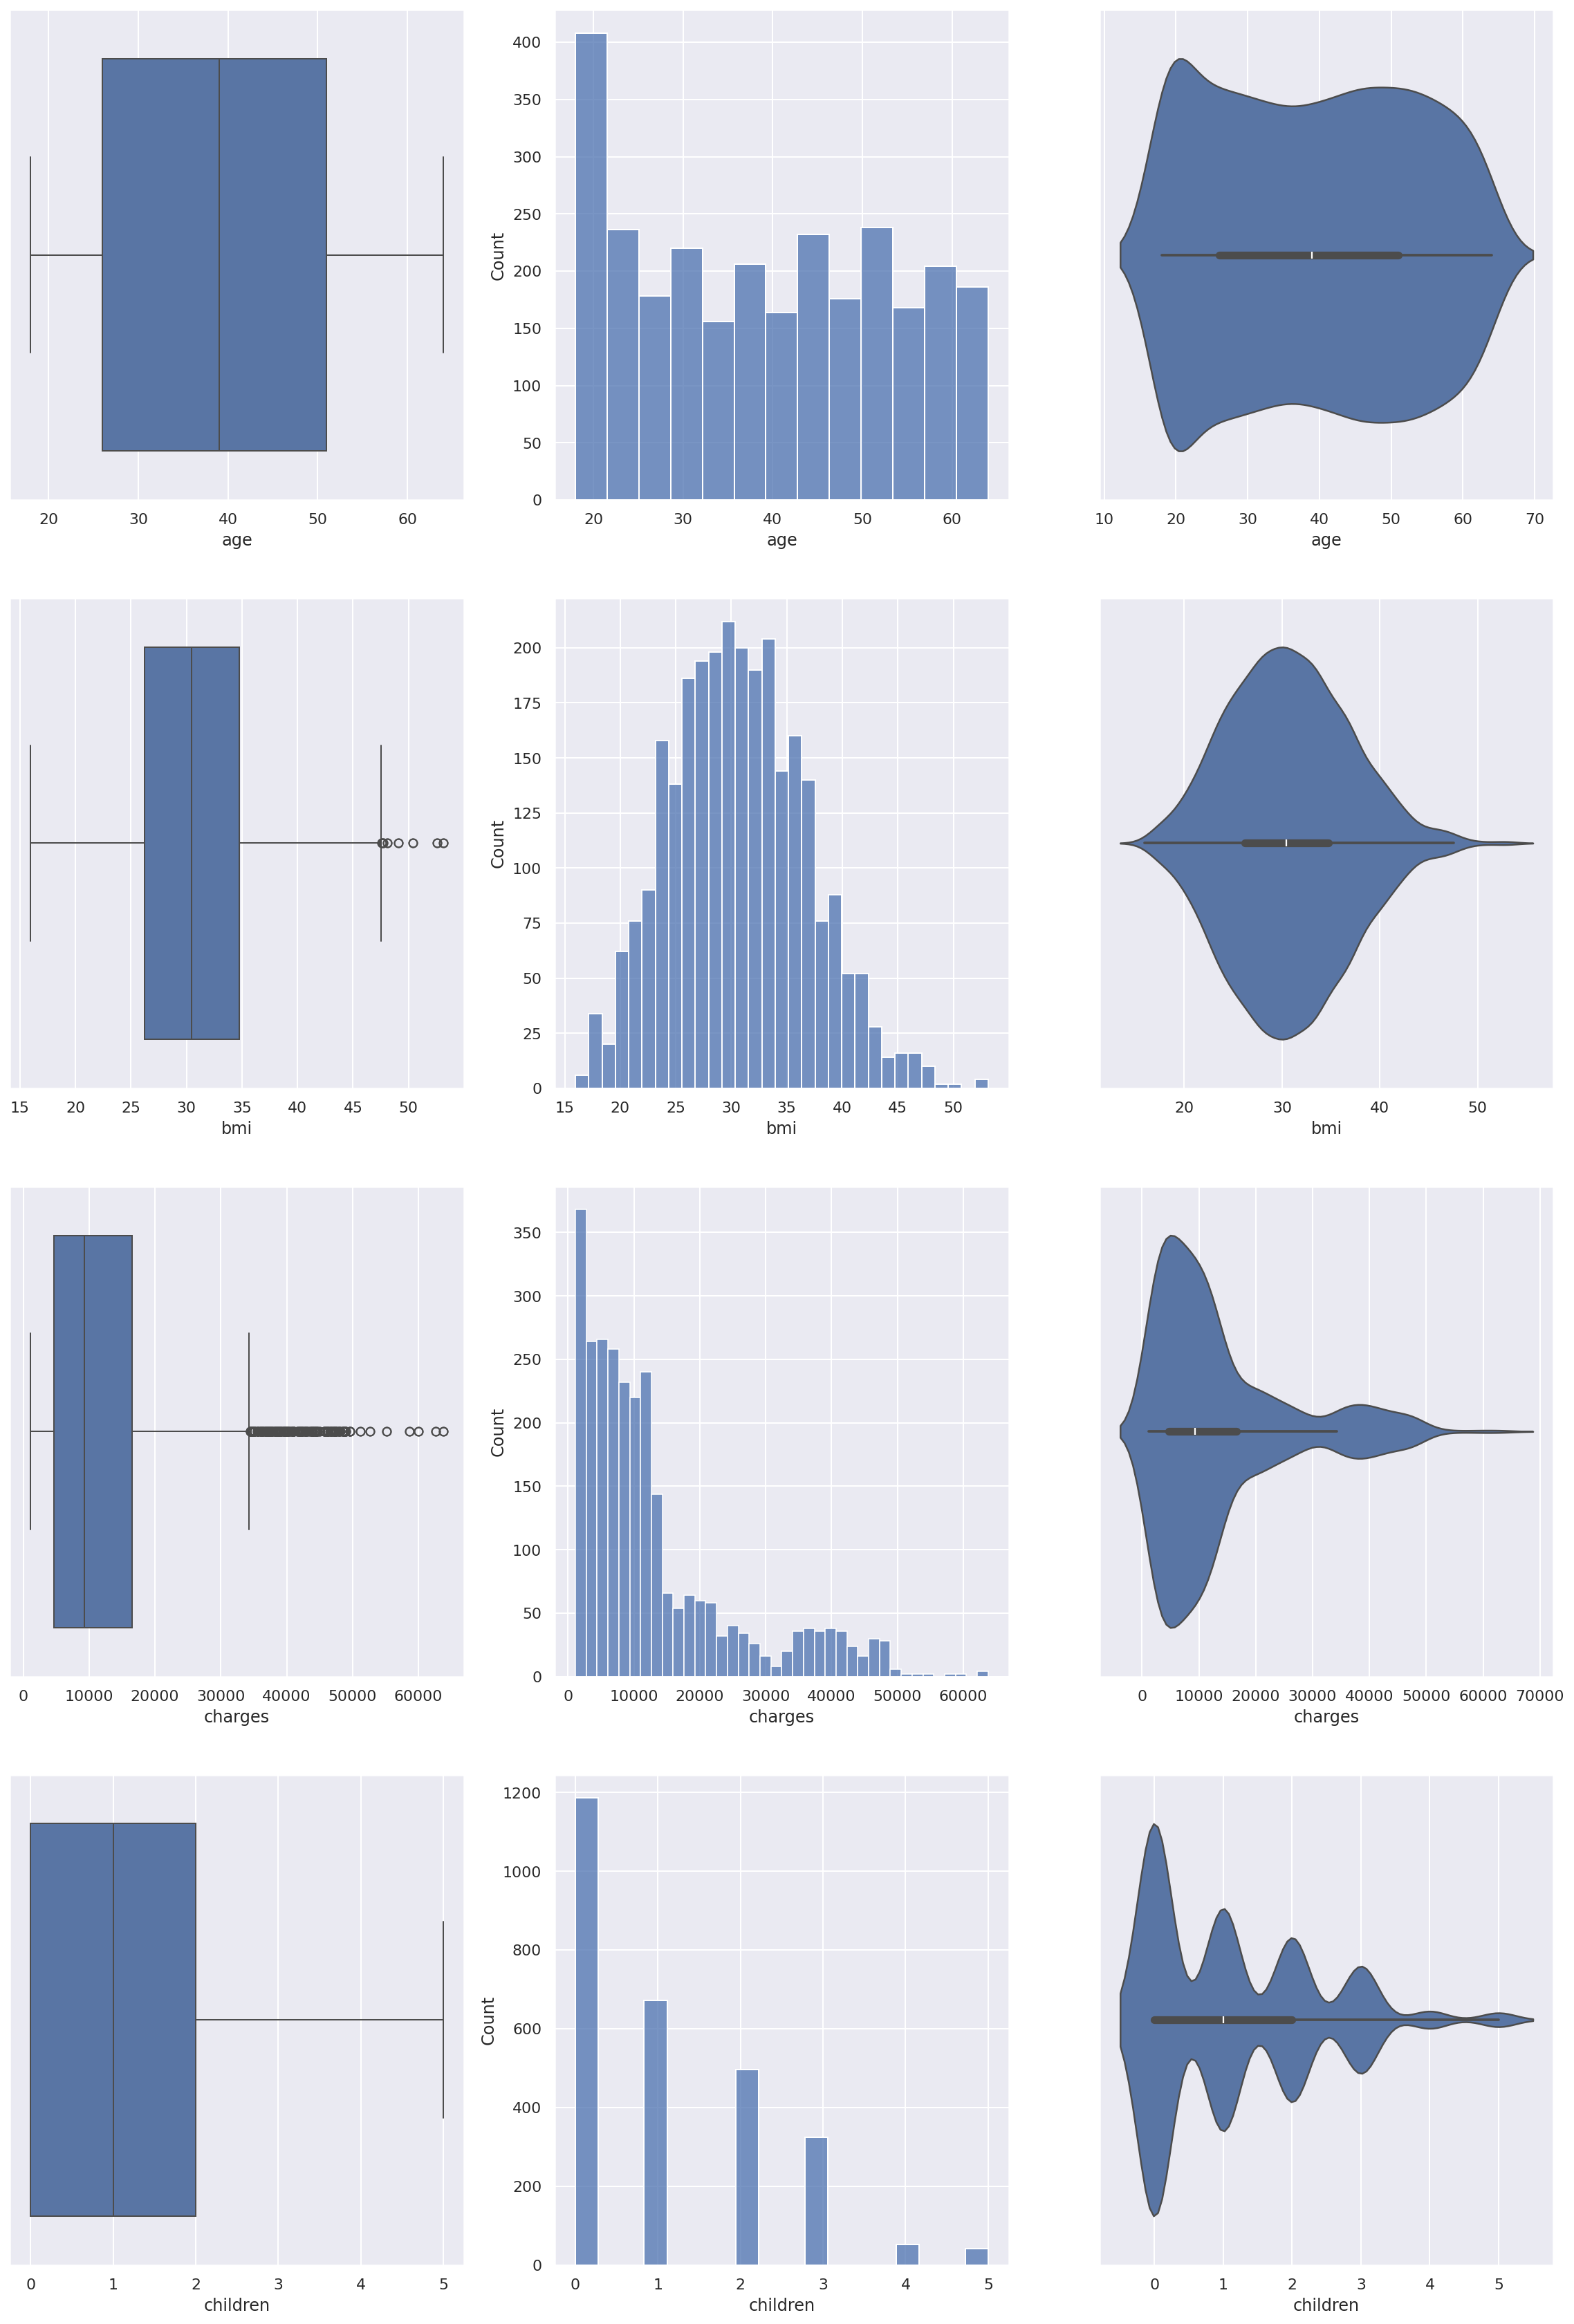

In [ ]:
# Draw the distributions of all numeric variables
f, axes = plt.subplots(4, 3, figsize=(20, 30))

count = 0
for var in intandfloat_cleaned:
    sb.boxplot(data = intandfloat_cleaned[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = intandfloat_cleaned[var], ax = axes[count,1])
    sb.violinplot(data = intandfloat_cleaned[var], orient = "h", ax = axes[count,2])
    count += 1

In [ ]:
intandfloat_cleaned.corr()

age       bmi   charges  children
age       1.000000  0.113048  0.298624  0.037574
bmi       0.113048  1.000000  0.199846 -0.001492
charges   0.298624  0.199846  1.000000  0.066442
children  0.037574 -0.001492  0.066442  1.000000

<Axes: >

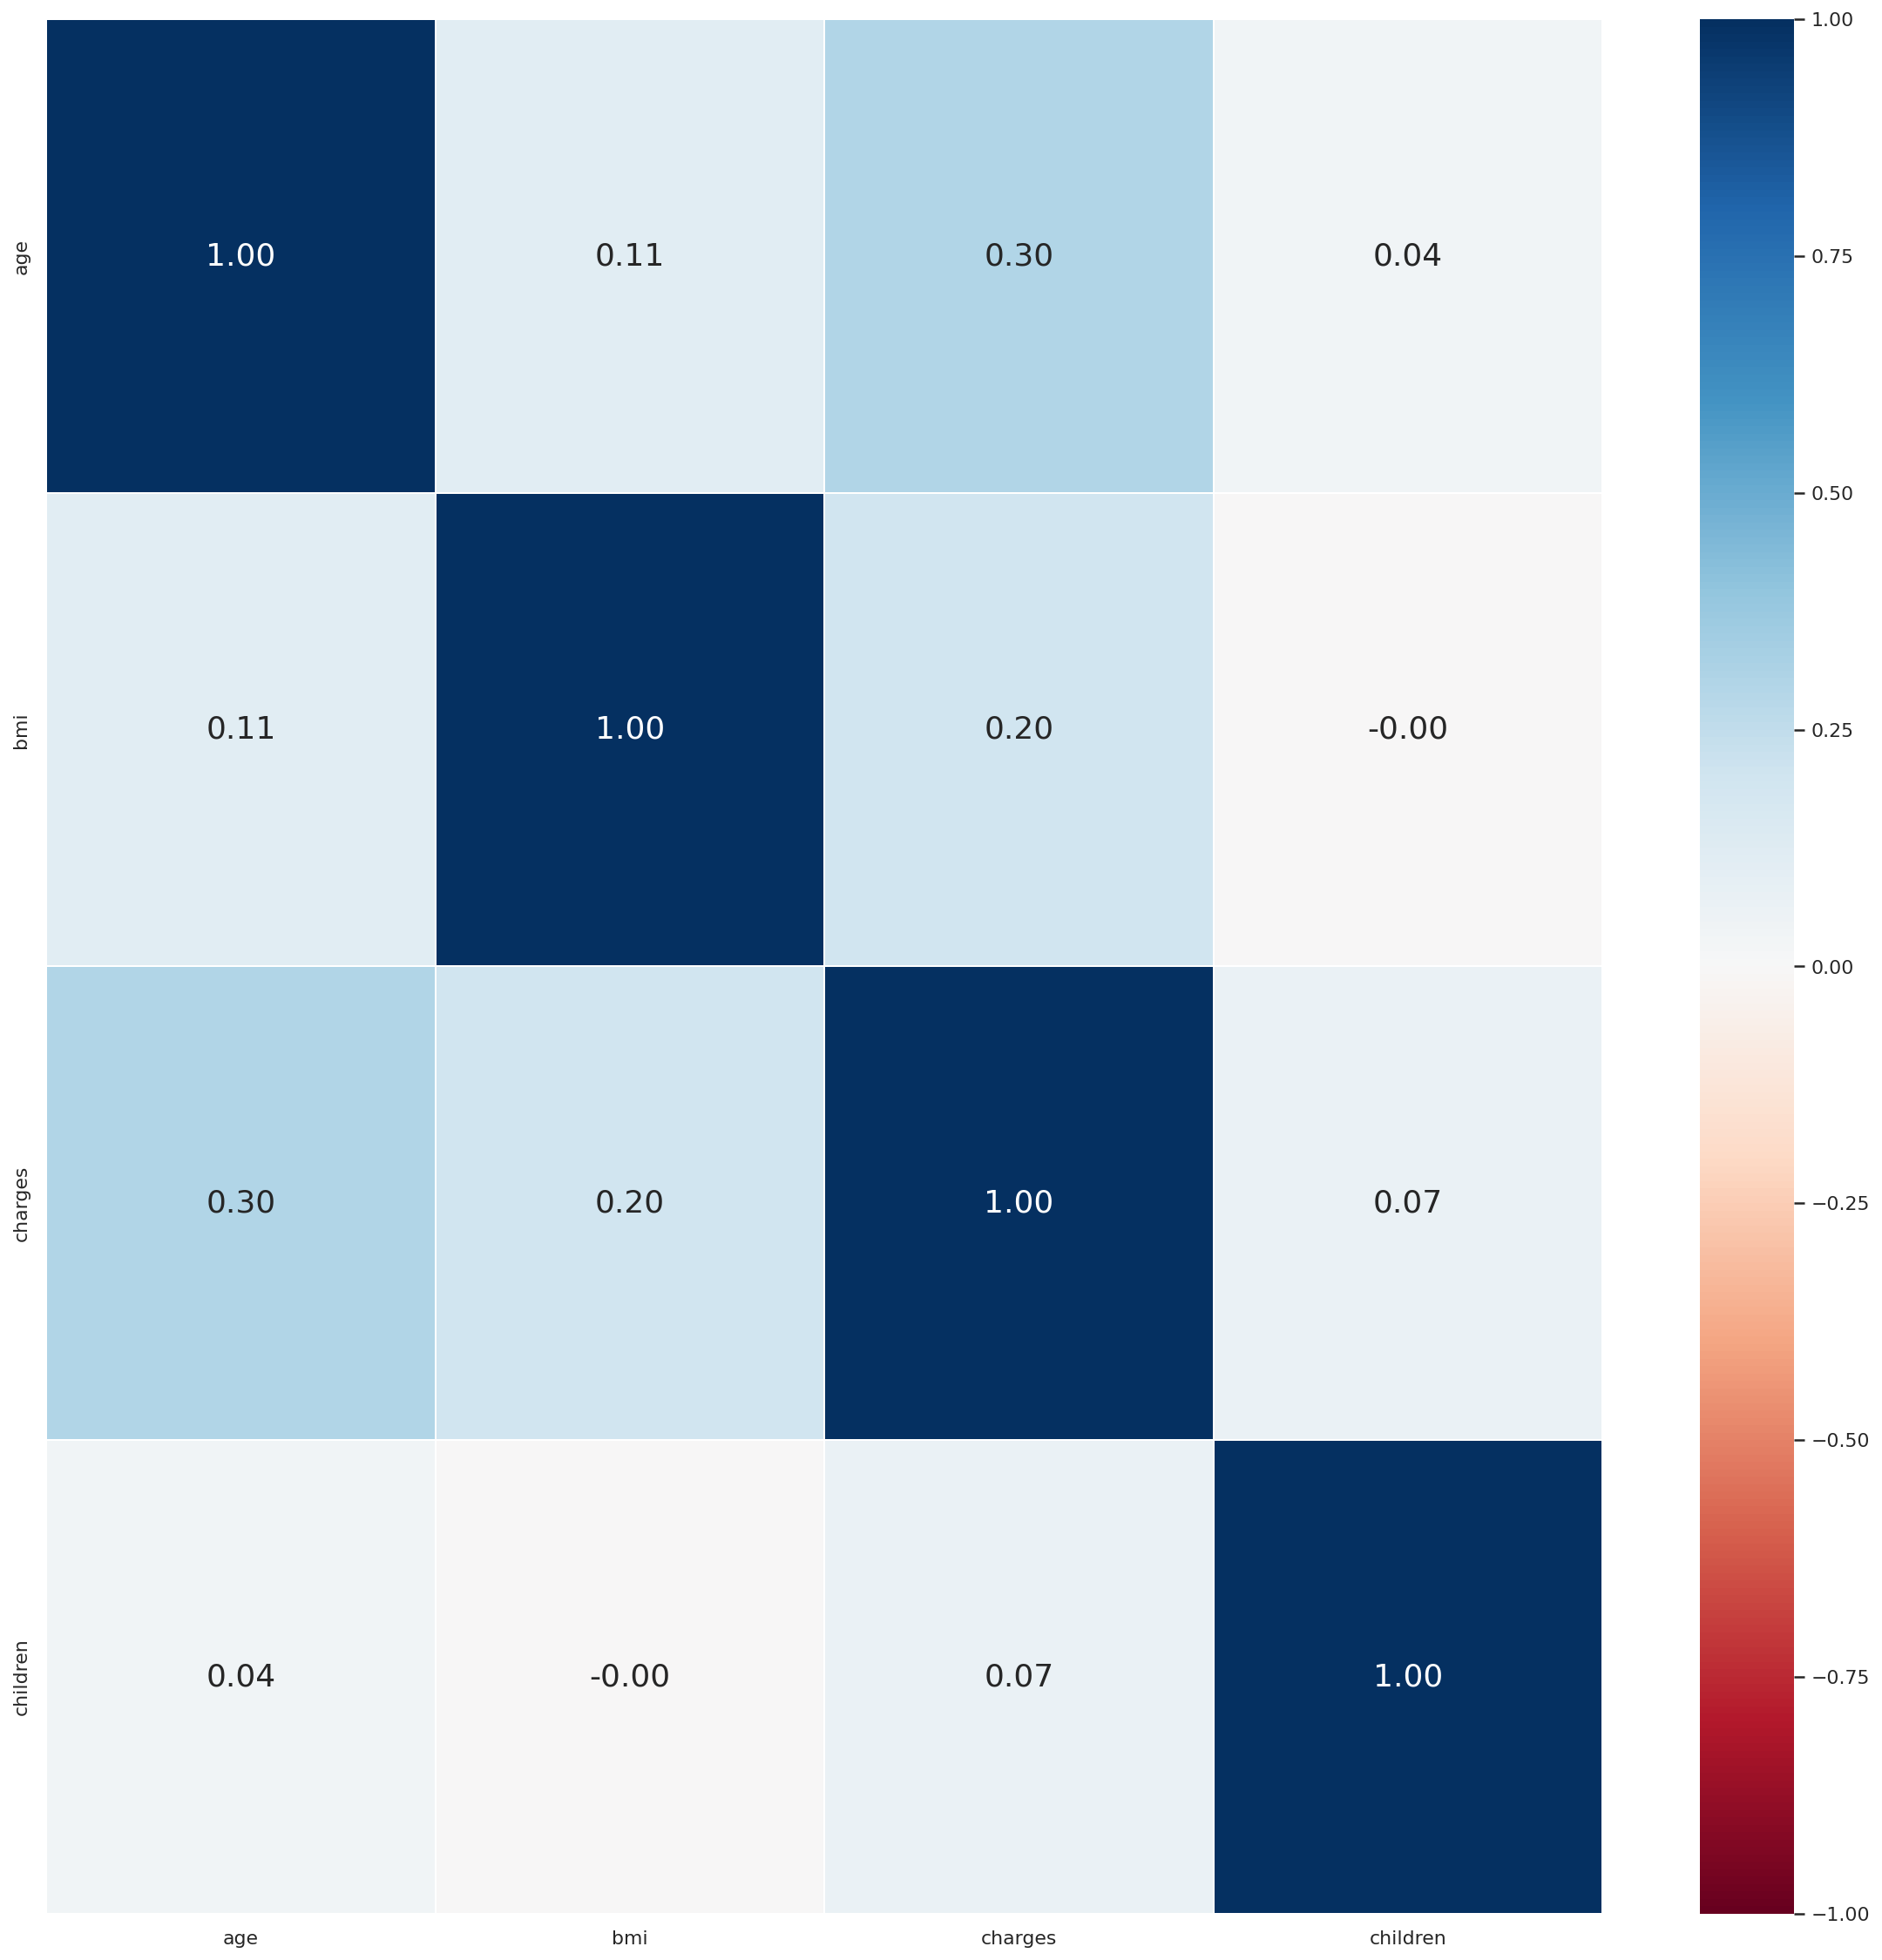

In [ ]:
# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(20, 20))
sb.heatmap(intandfloat_cleaned.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

We observe the highest correlation between charges and age, at 0.45 \(moderate positive correlation\).  



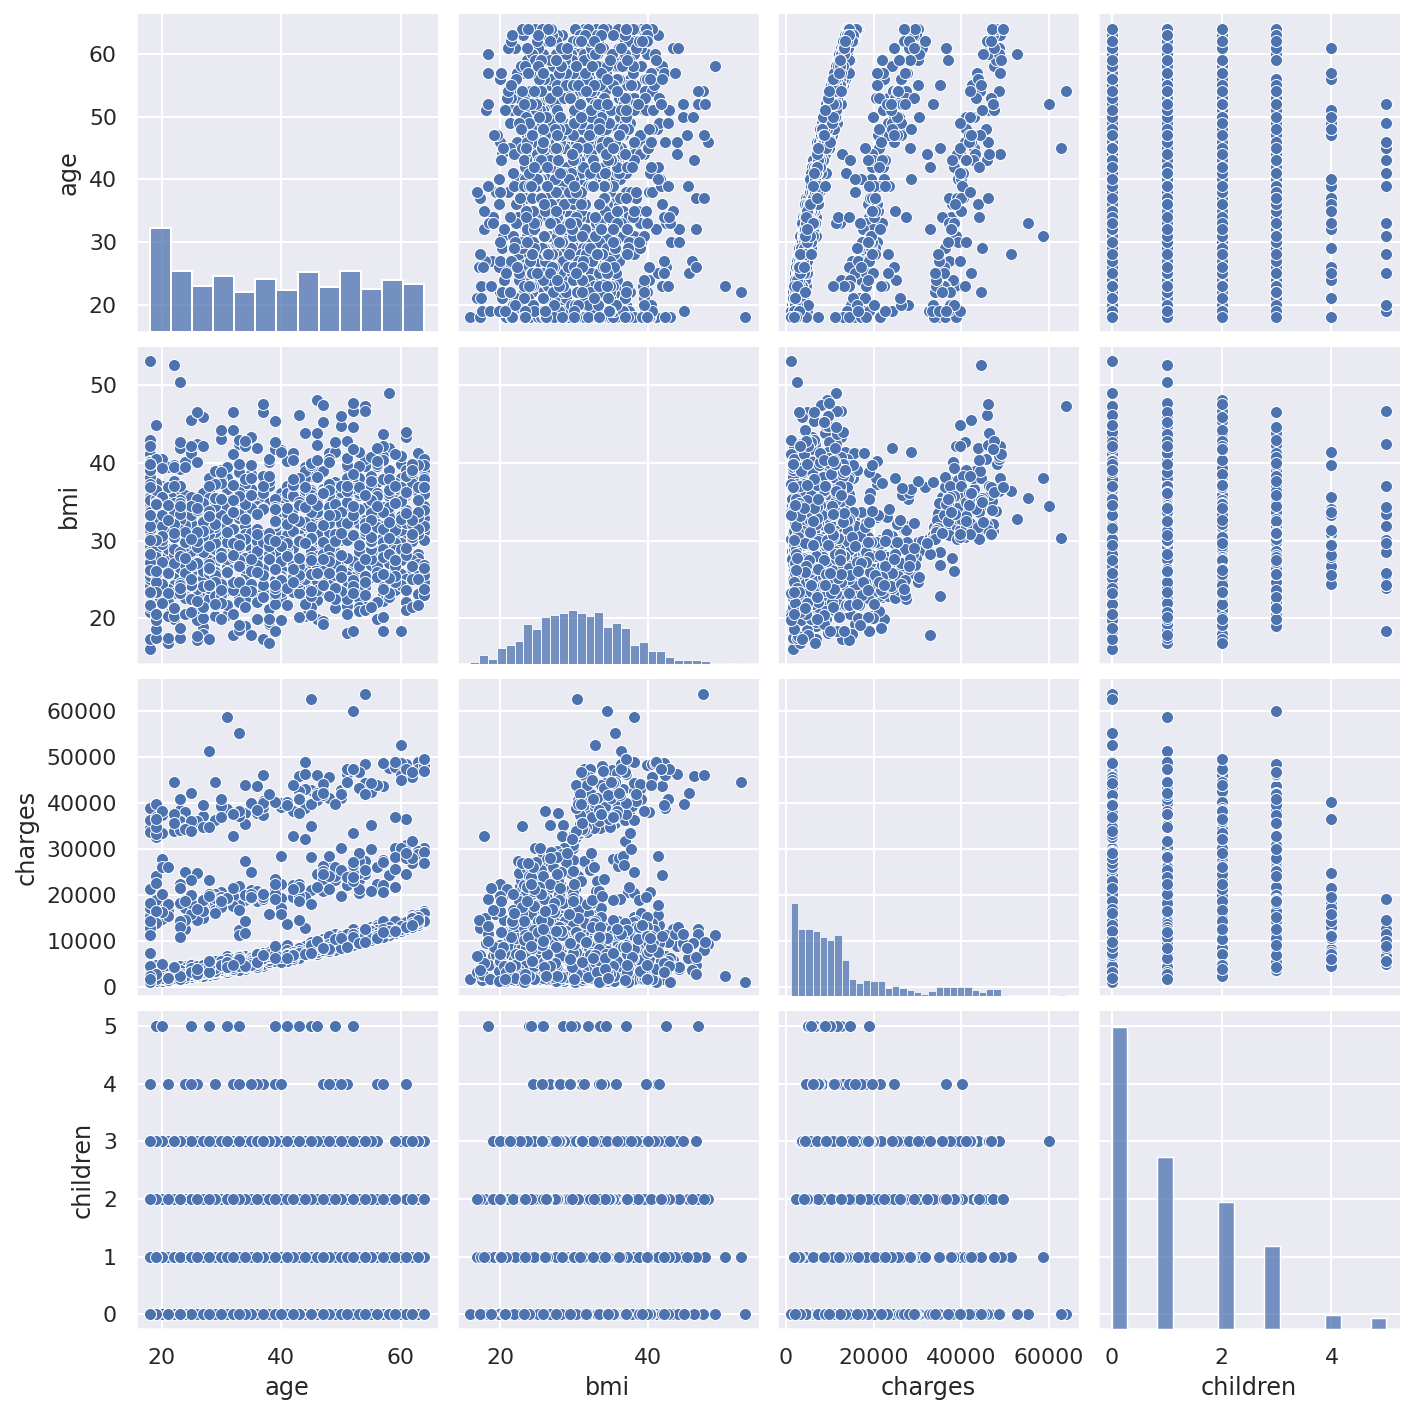

In [ ]:
# Draw pairs of variables against one another
sb.pairplot(data = intandfloat_cleaned)

<span style='font-size:x-large'>**Looking at categorical data:**</span>  



In [ ]:
print(medIn_cleaned.head())

   age     sex     bmi  healthyweight  children smoker     region      charges
0   19  female  27.900              2         0    yes  southwest  16884.92400
1   18    male  33.770              3         1     no  southeast   1725.55230
2   28    male  33.000              3         3     no  southeast   4449.46200
3   33    male  22.705              1         0     no  northwest  21984.47061
4   32    male  28.880              2         0     no  northwest   3866.85520


In [ ]:
medIn_cleaned['sex'].value_counts()

sex
male      1406
female    1366
Name: count, dtype: int64

<Axes: xlabel='sex', ylabel='charges'>

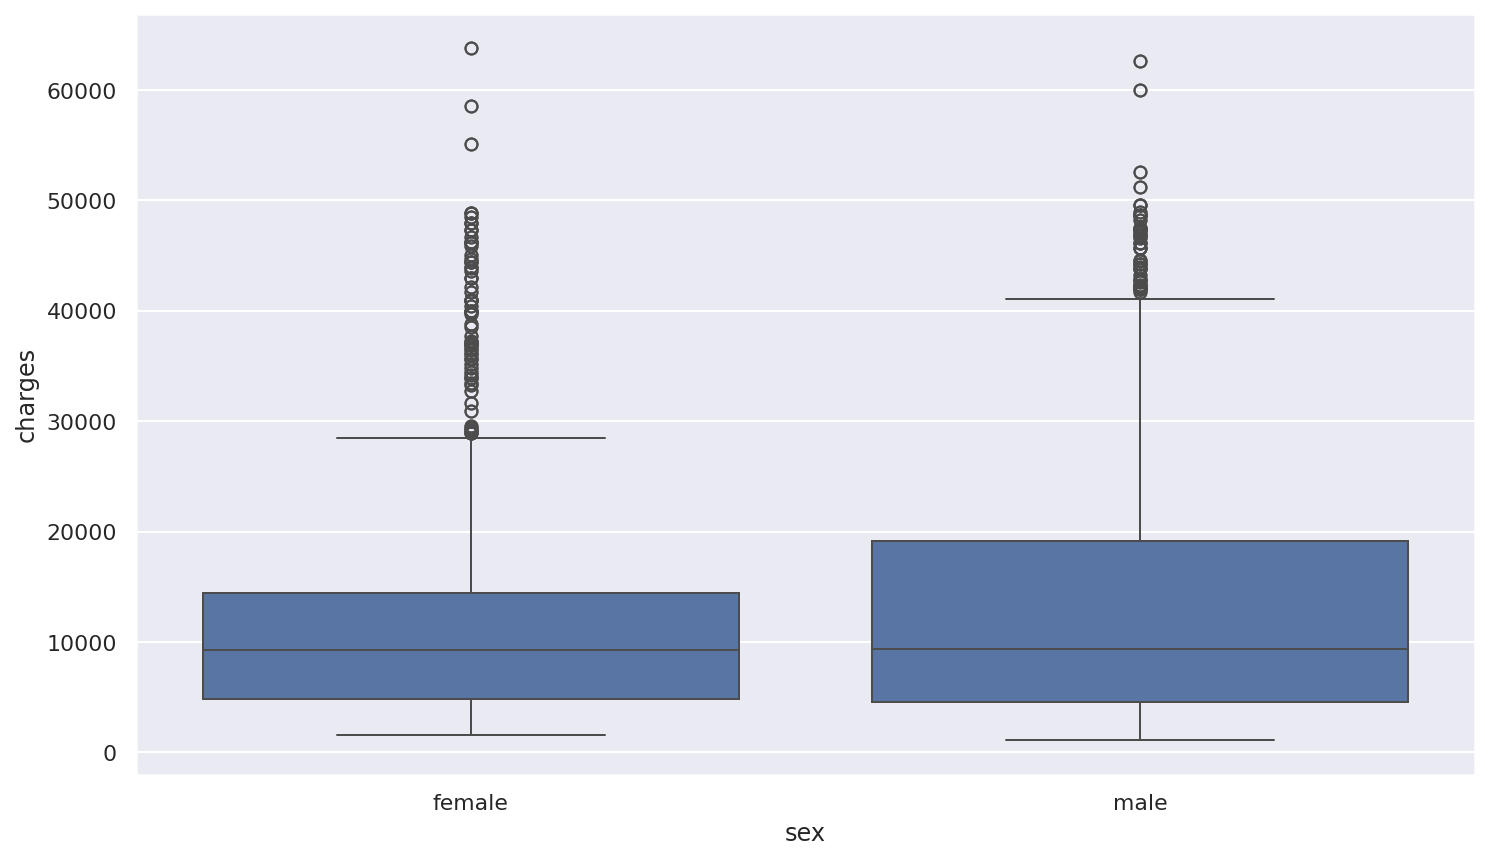

In [ ]:
sb.boxplot(data=medIn_cleaned, y=medIn_cleaned['charges'], x=medIn_cleaned['sex'])

In [ ]:
medIn_cleaned['smoker'].value_counts()

smoker
no     2208
yes     564
Name: count, dtype: int64

<Axes: xlabel='smoker', ylabel='charges'>

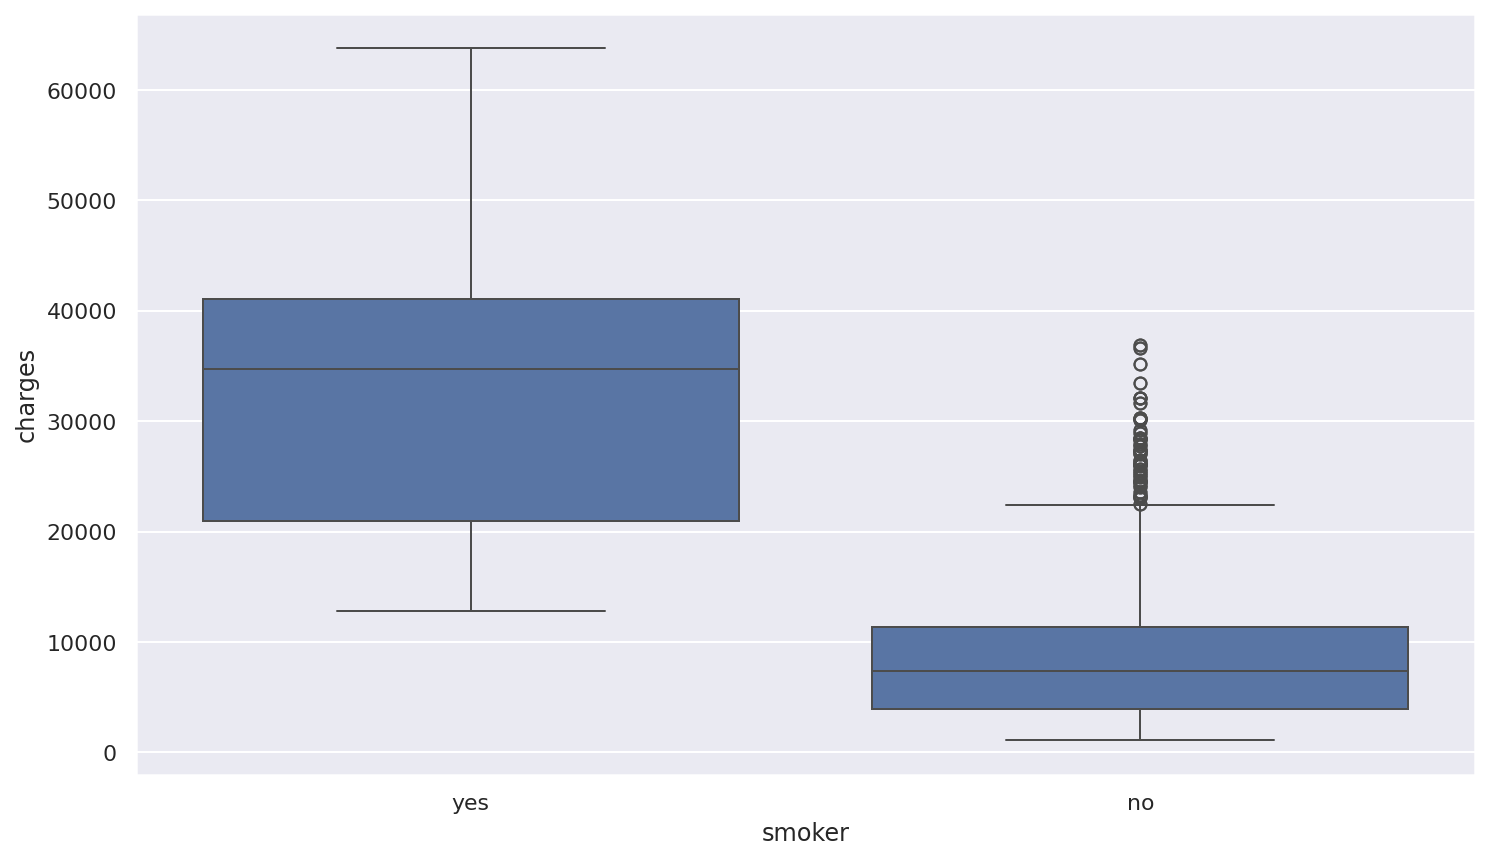

In [ ]:
sb.boxplot(data=medIn_cleaned, y=medIn_cleaned['charges'], x=medIn_cleaned['smoker'])

In general, we observe that smokers incur higher medical insurance charges, as seen from how the lowest charge for a smoker almost coincides with the 3rd quartile \(75th percentile\) of non\-smokers.  



In [ ]:
medIn_cleaned['region'].value_counts()

region
southeast    766
southwest    684
northwest    664
northeast    658
Name: count, dtype: int64

<Axes: xlabel='region', ylabel='charges'>

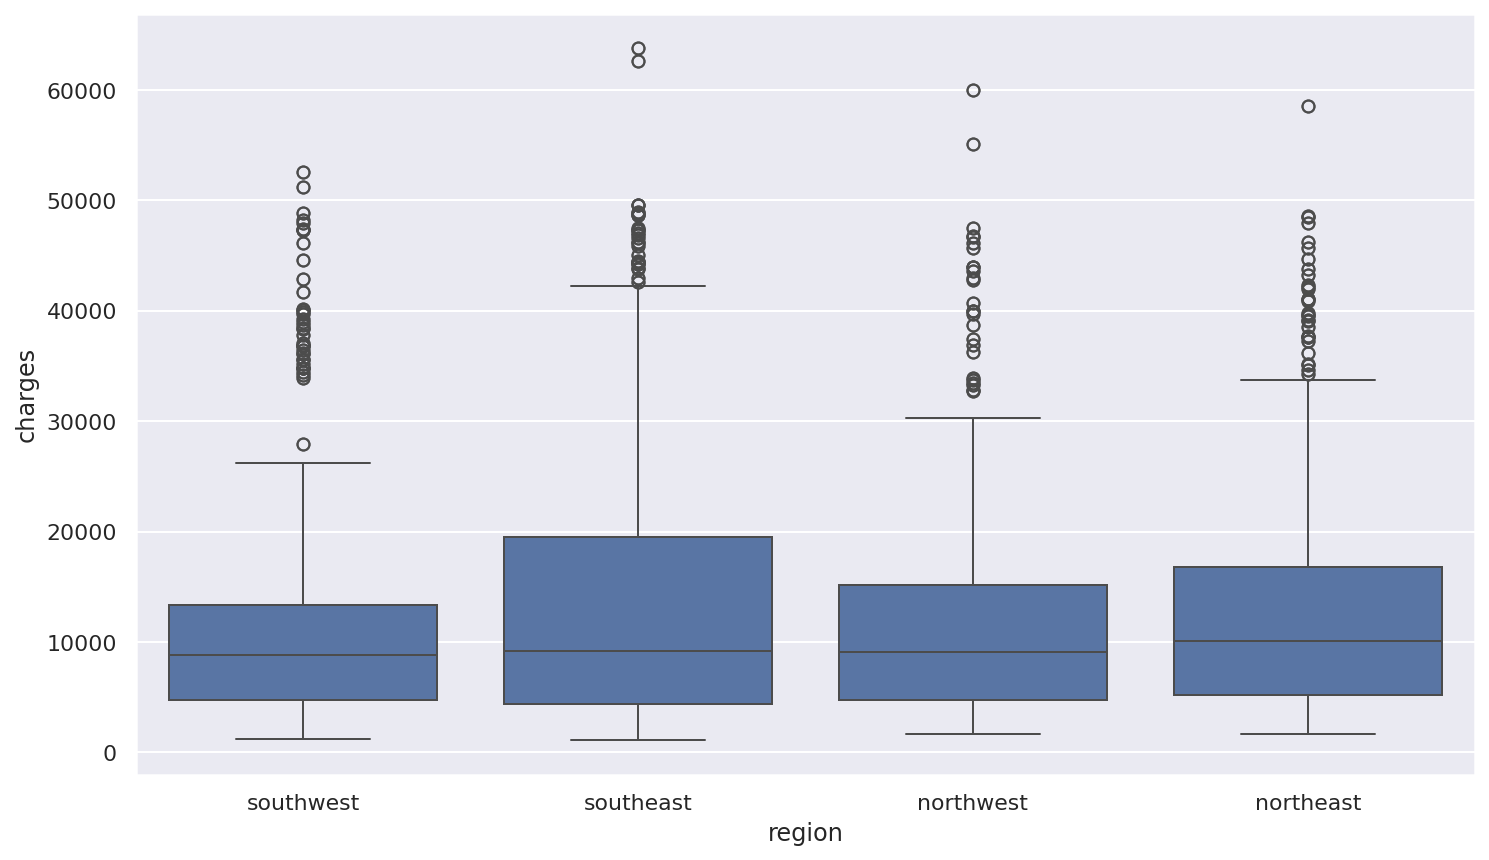

In [ ]:
sb.boxplot(data=medIn_cleaned, y=medIn_cleaned['charges'], x=medIn_cleaned['region'])

In [ ]:
medIn_cleaned['healthyweight'].value_counts()

healthyweight
3    1496
2     772
1     464
0      40
Name: count, dtype: int64

<Axes: xlabel='healthyweight', ylabel='charges'>

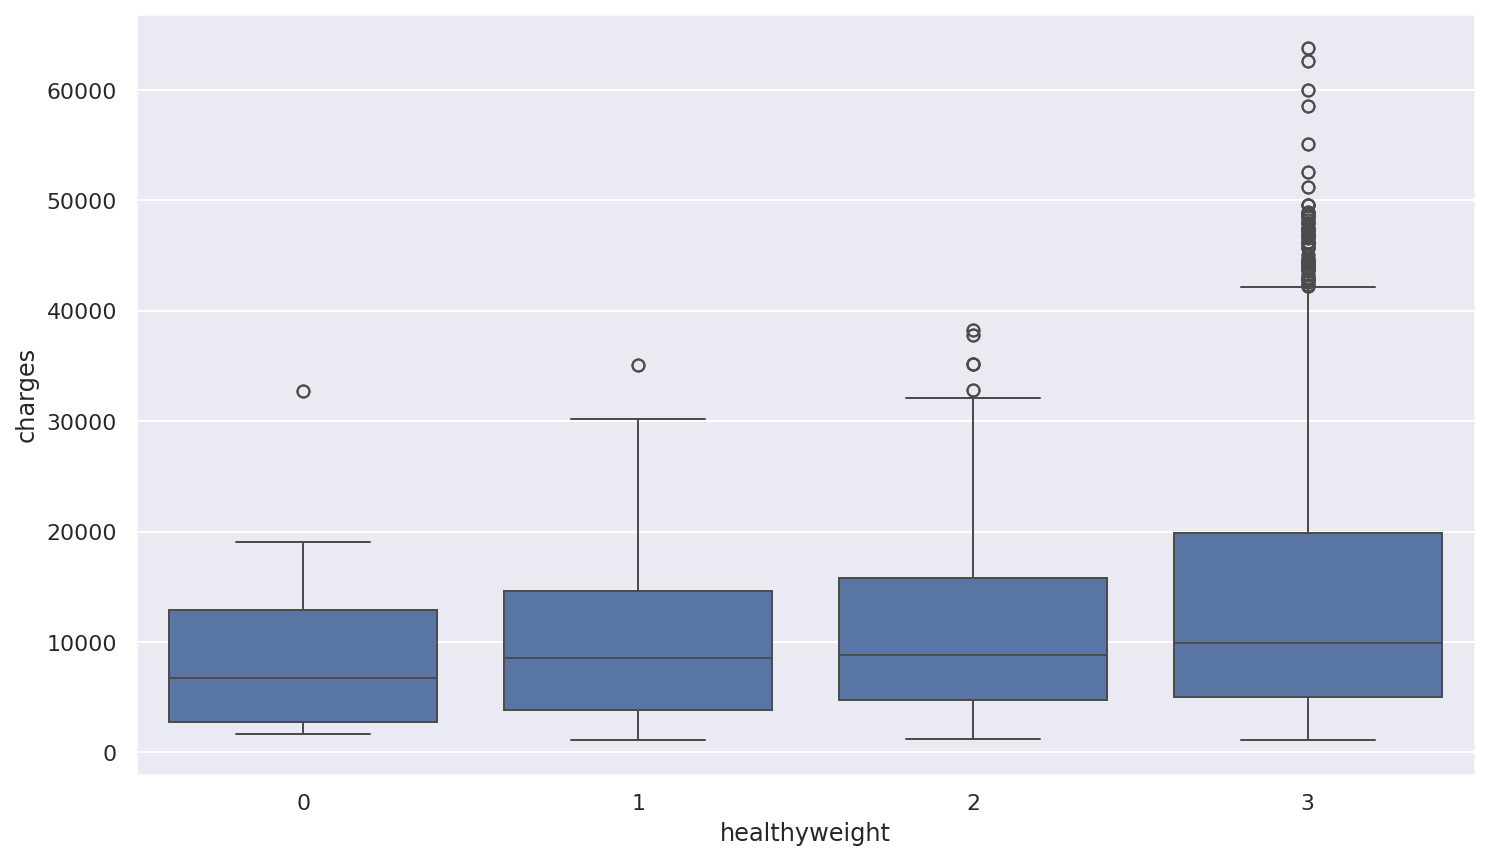

In [ ]:
sb.boxplot(data=medIn_cleaned, y=medIn_cleaned['charges'], x=medIn_cleaned['healthyweight'])

In [ ]:
medIn_cleaned_copy = medIn_cleaned.copy()

# Mapping 'yes' to 1 and 'no' to 0 for 'smoker' column, and changing data type to boolean
medIn_cleaned_copy['smoker'] = (medIn_cleaned_copy['smoker'] == 'yes').astype(bool)

# Mapping 'female' to 1 and 'male' to 0 for 'sex' column, and changing data type to boolean
medIn_cleaned_copy['sex'] = (medIn_cleaned_copy['sex'] == 'female').astype(bool)

print(medIn_cleaned_copy.head())

   age    sex     bmi  healthyweight  children  smoker     region      charges
0   19   True  27.900              2         0    True  southwest  16884.92400
1   18  False  33.770              2         1   False  southeast   1725.55230
2   28  False  33.000              2         3   False  southeast   4449.46200
3   33  False  22.705              1         0   False  northwest  21984.47061
4   32  False  28.880              2         0   False  northwest   3866.85520


### **Linear Regression**



##### Age as only predictor

In [ ]:
# With seed
seed_value = 42
np.random.seed(seed_value)

X = pd.DataFrame(medIn_cleaned[['age']])
y = pd.DataFrame(medIn_cleaned['charges'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

<Axes: >

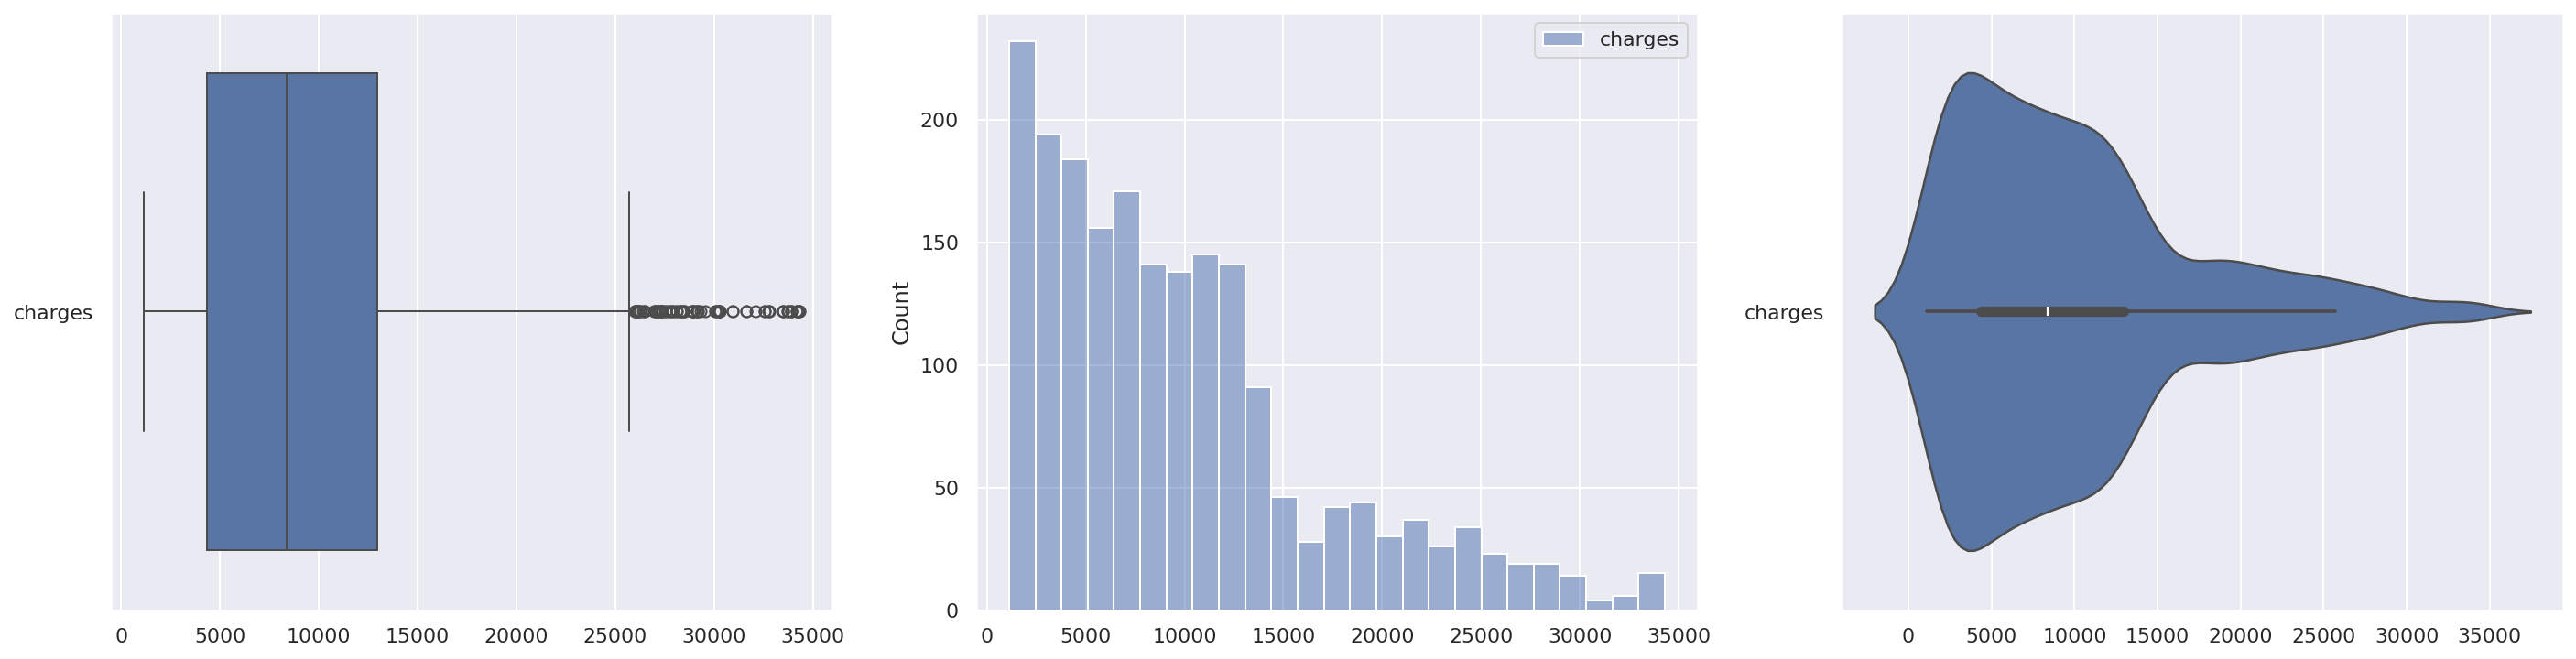

In [ ]:
# Visualize the distribution of the target variable

f, axes = plt.subplots(1, 3, figsize=(24, 6))
sb.boxplot(data = y_train, orient = "h", ax = axes[0])
sb.histplot(data = y_train, ax = axes[1])
sb.violinplot(data = y_train, orient = "h", ax = axes[2])

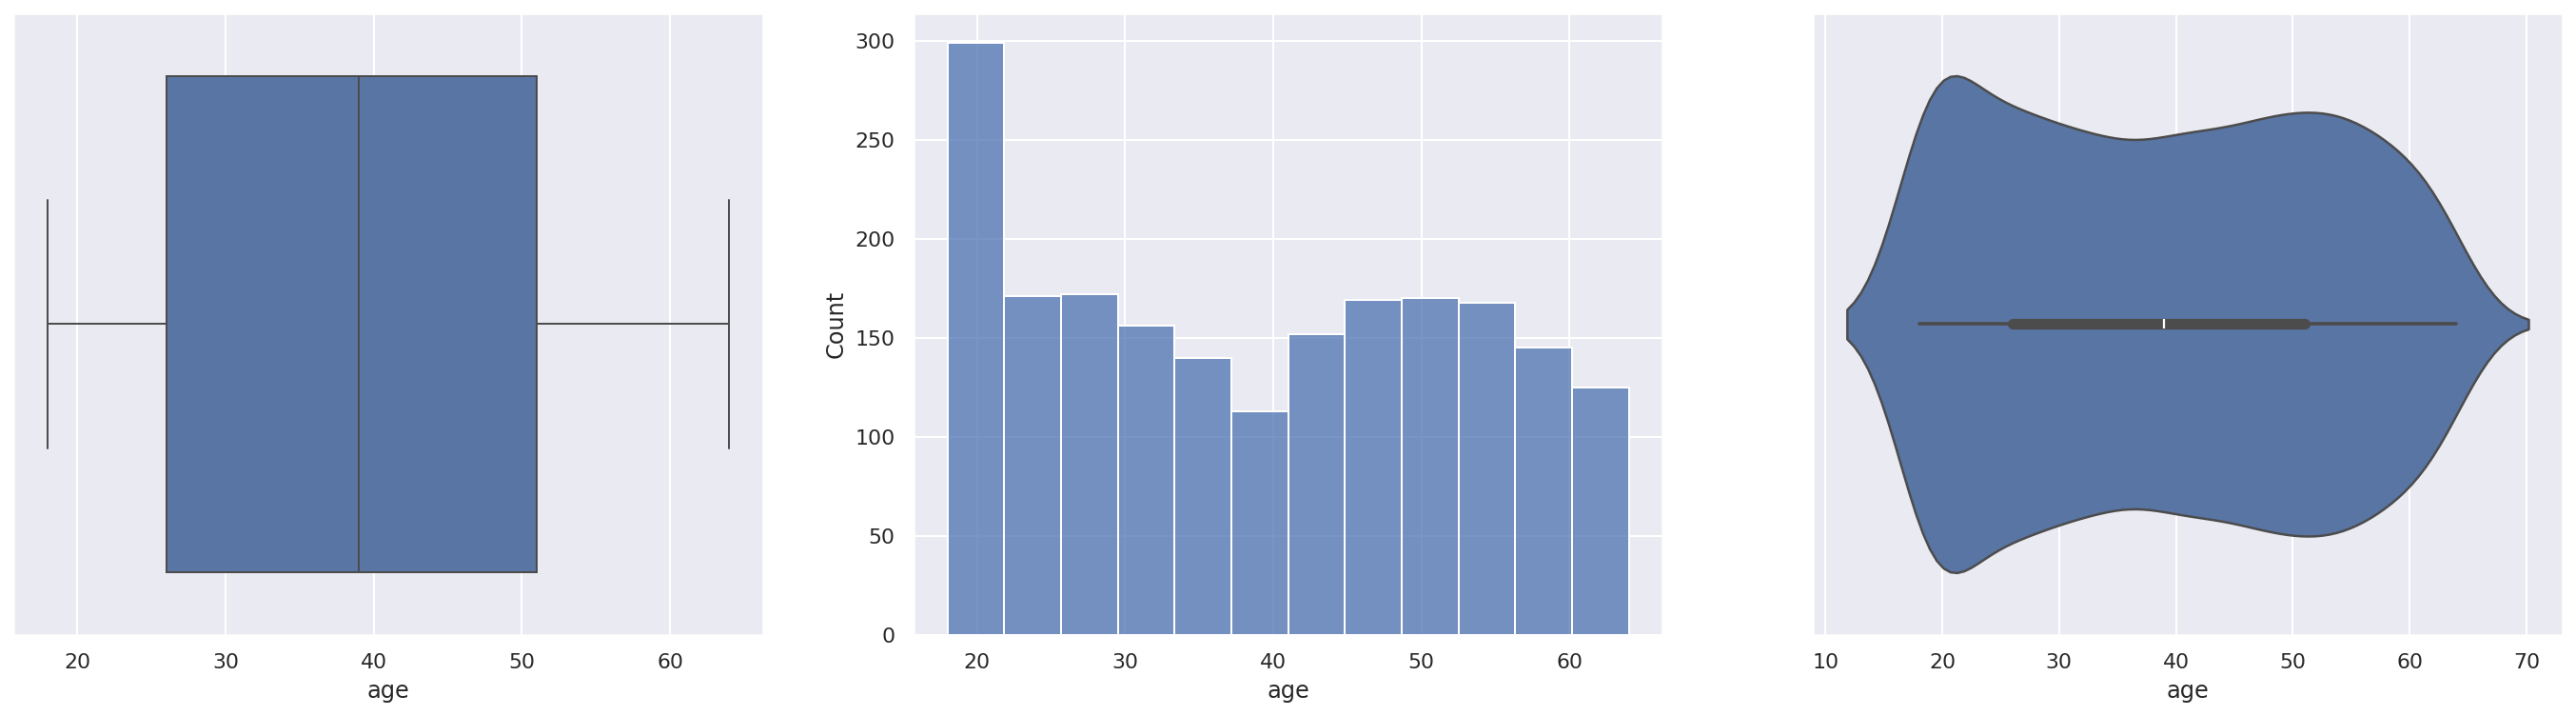

In [ ]:
# Visualize the distribution of the predictor variables

f, axes = plt.subplots(1, 3, figsize=(24, 6))

for var in X_train:
    sb.boxplot(data = X_train[var], orient = "h", ax = axes[0])
    sb.histplot(data = X_train[var], ax = axes[1])
    sb.violinplot(data = X_train[var], orient = "h", ax = axes[2])

<Axes: >

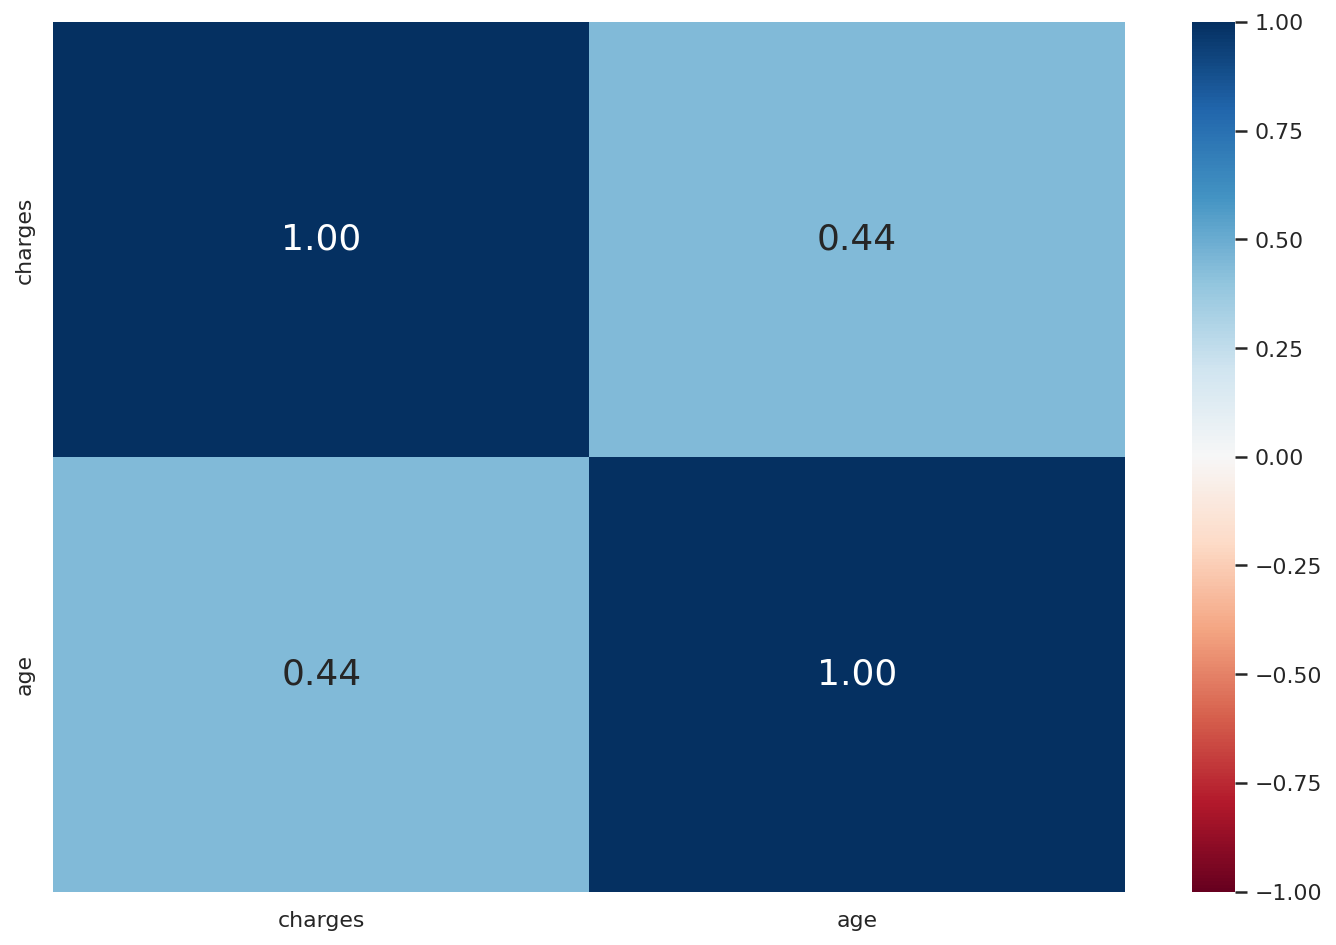

In [ ]:
# Correlation between Response and the Predictors
trainDF = pd.concat([y_train, X_train], axis = 1).reindex(y_train.index)

f = plt.figure(figsize=(12, 8))
sb.heatmap(trainDF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f",
           annot_kws = {"size" : 18}, cmap = "RdBu")

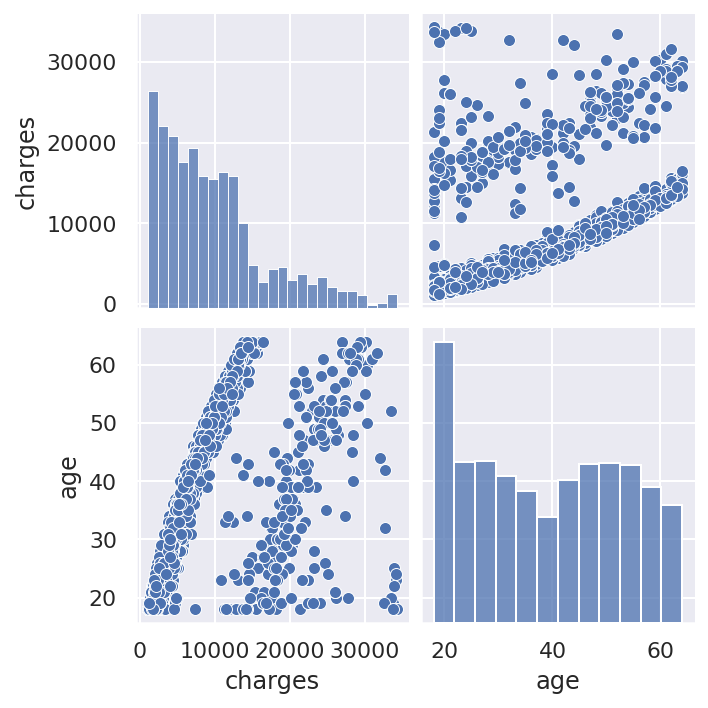

In [ ]:
sb.pairplot(data = trainDF)

In [ ]:
# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"])

Intercept of Regression 	: b =  [1050.14122971]
Coefficients of Regression 	: a =  [[226.78453865]]



Predictors  Coefficients
0        age    226.784539

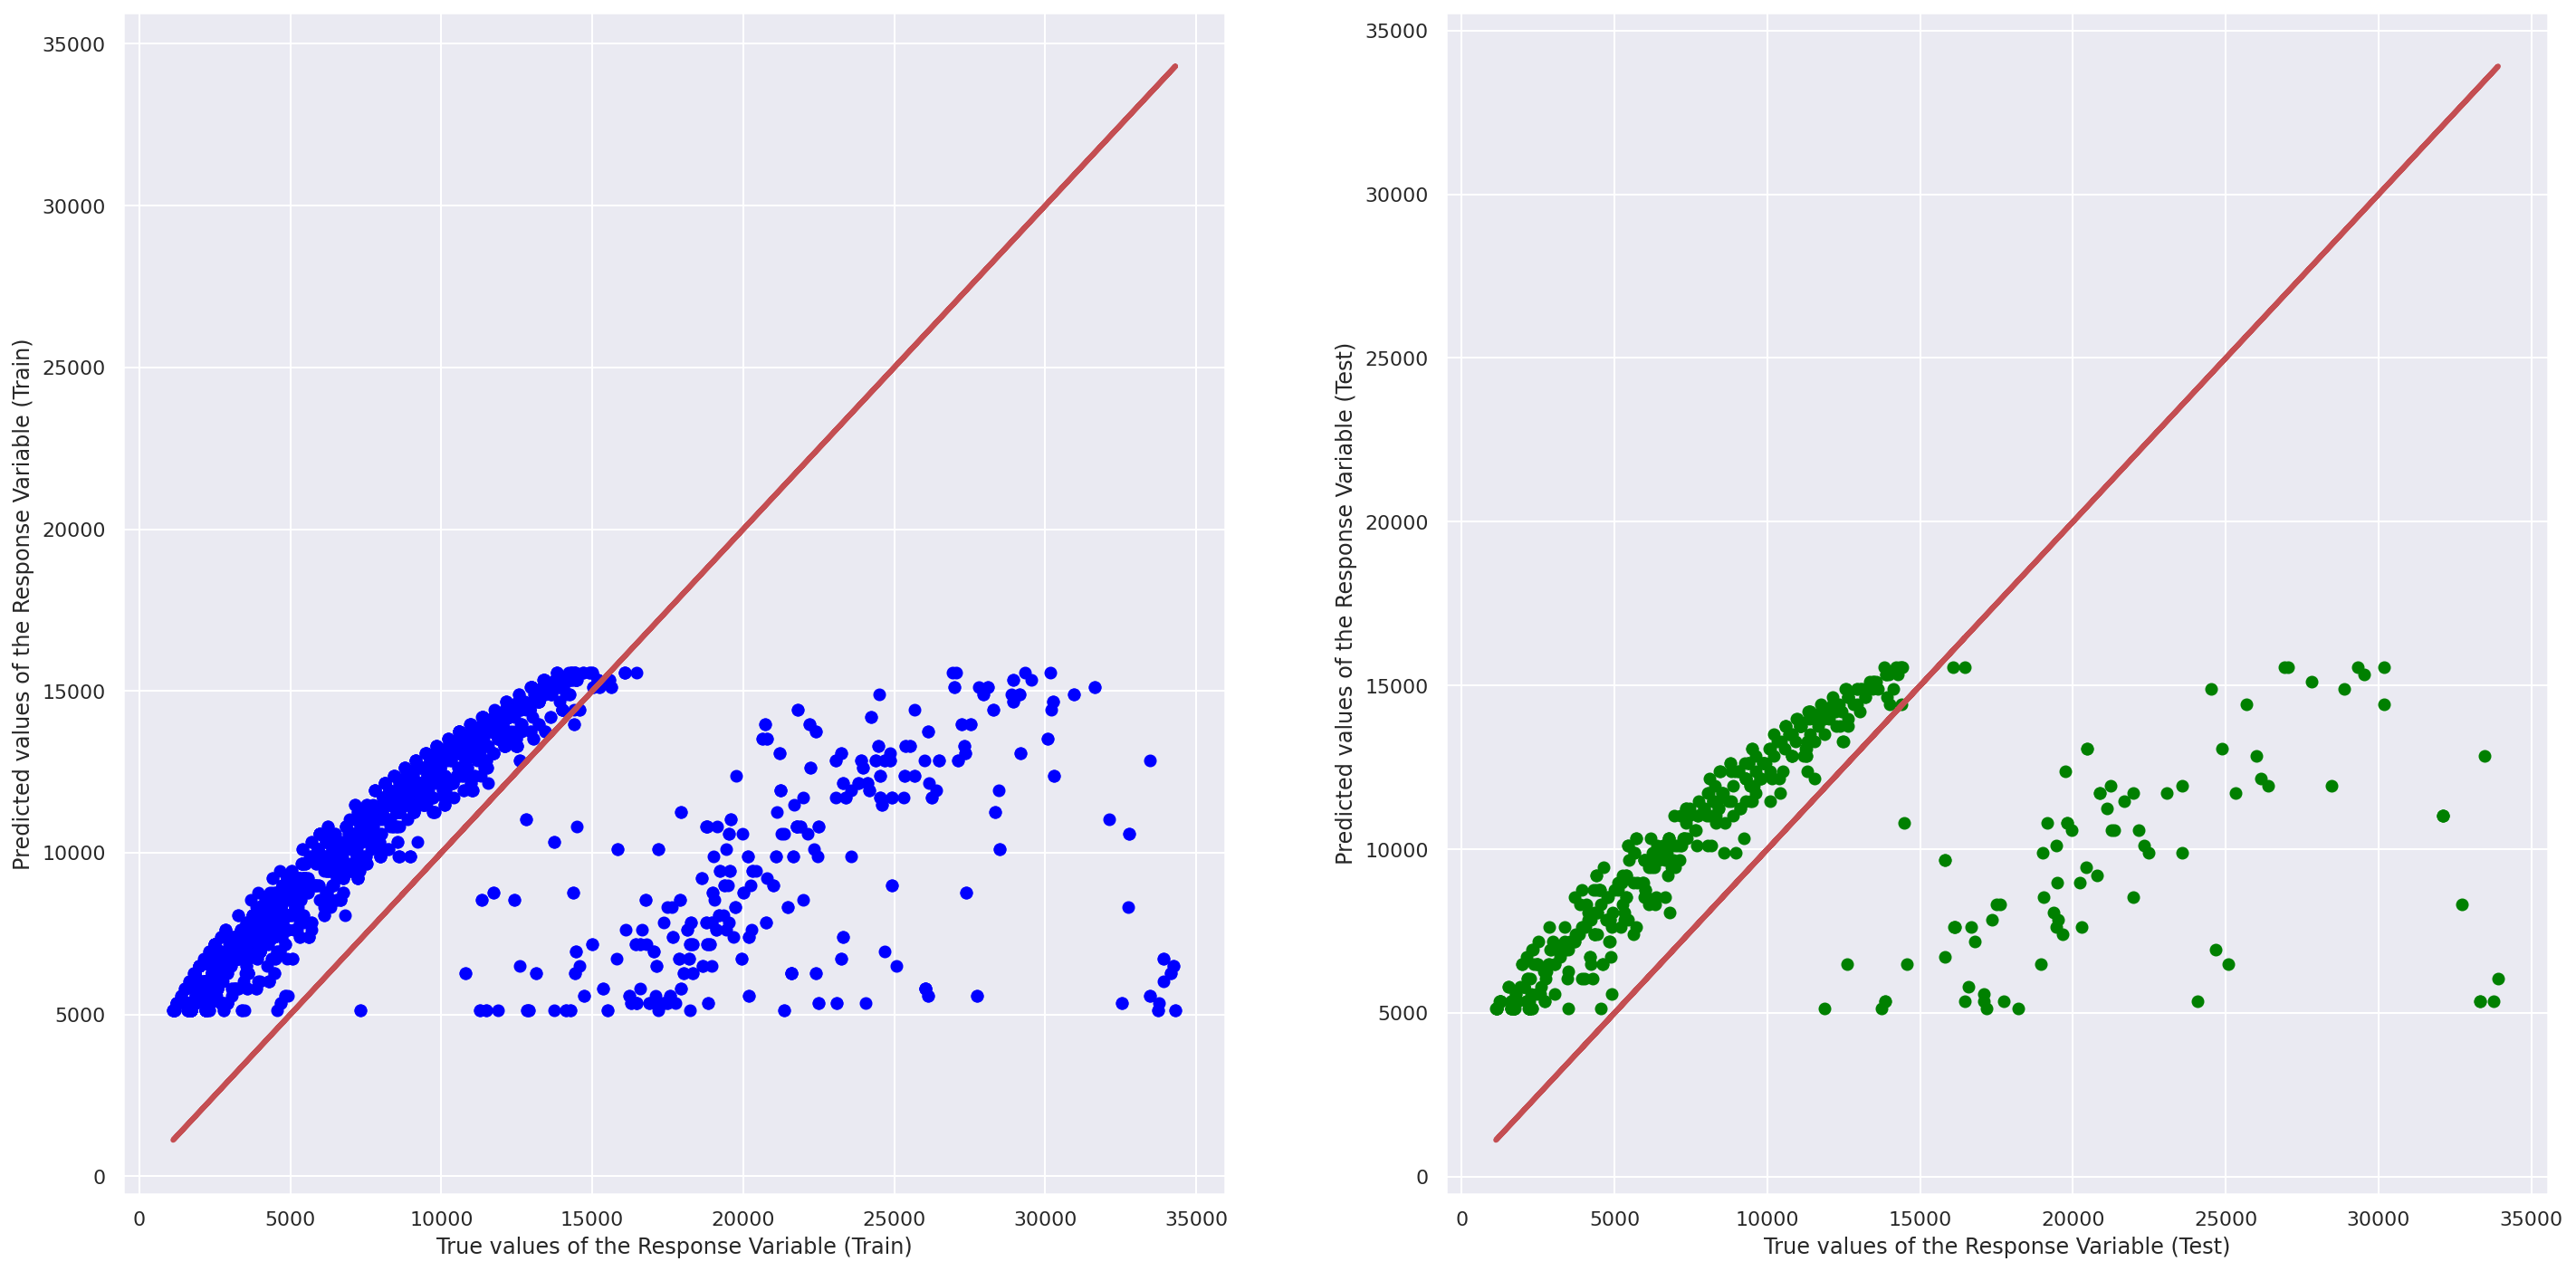

In [ ]:
# Predict the Total values from Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 3)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'r-', linewidth = 3)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [ ]:
# Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.19722040207709335
Mean Squared Error (MSE) 	: 41435346.402496636

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.21872966194683818
Mean Squared Error (MSE) 	: 39132624.36976453



<span style='font-size:medium'>As seen from the low R^2 values and high mean square errors, the linear model prediction is not accurate. This suggests that the cost of insurance does not increase linearly when compared with age. As such, we attempted polynomial regression to check if the model would predict insurance cost more accurately.</span>  



<span style='font-size:x-large'>Age & Children as predictor</span>  



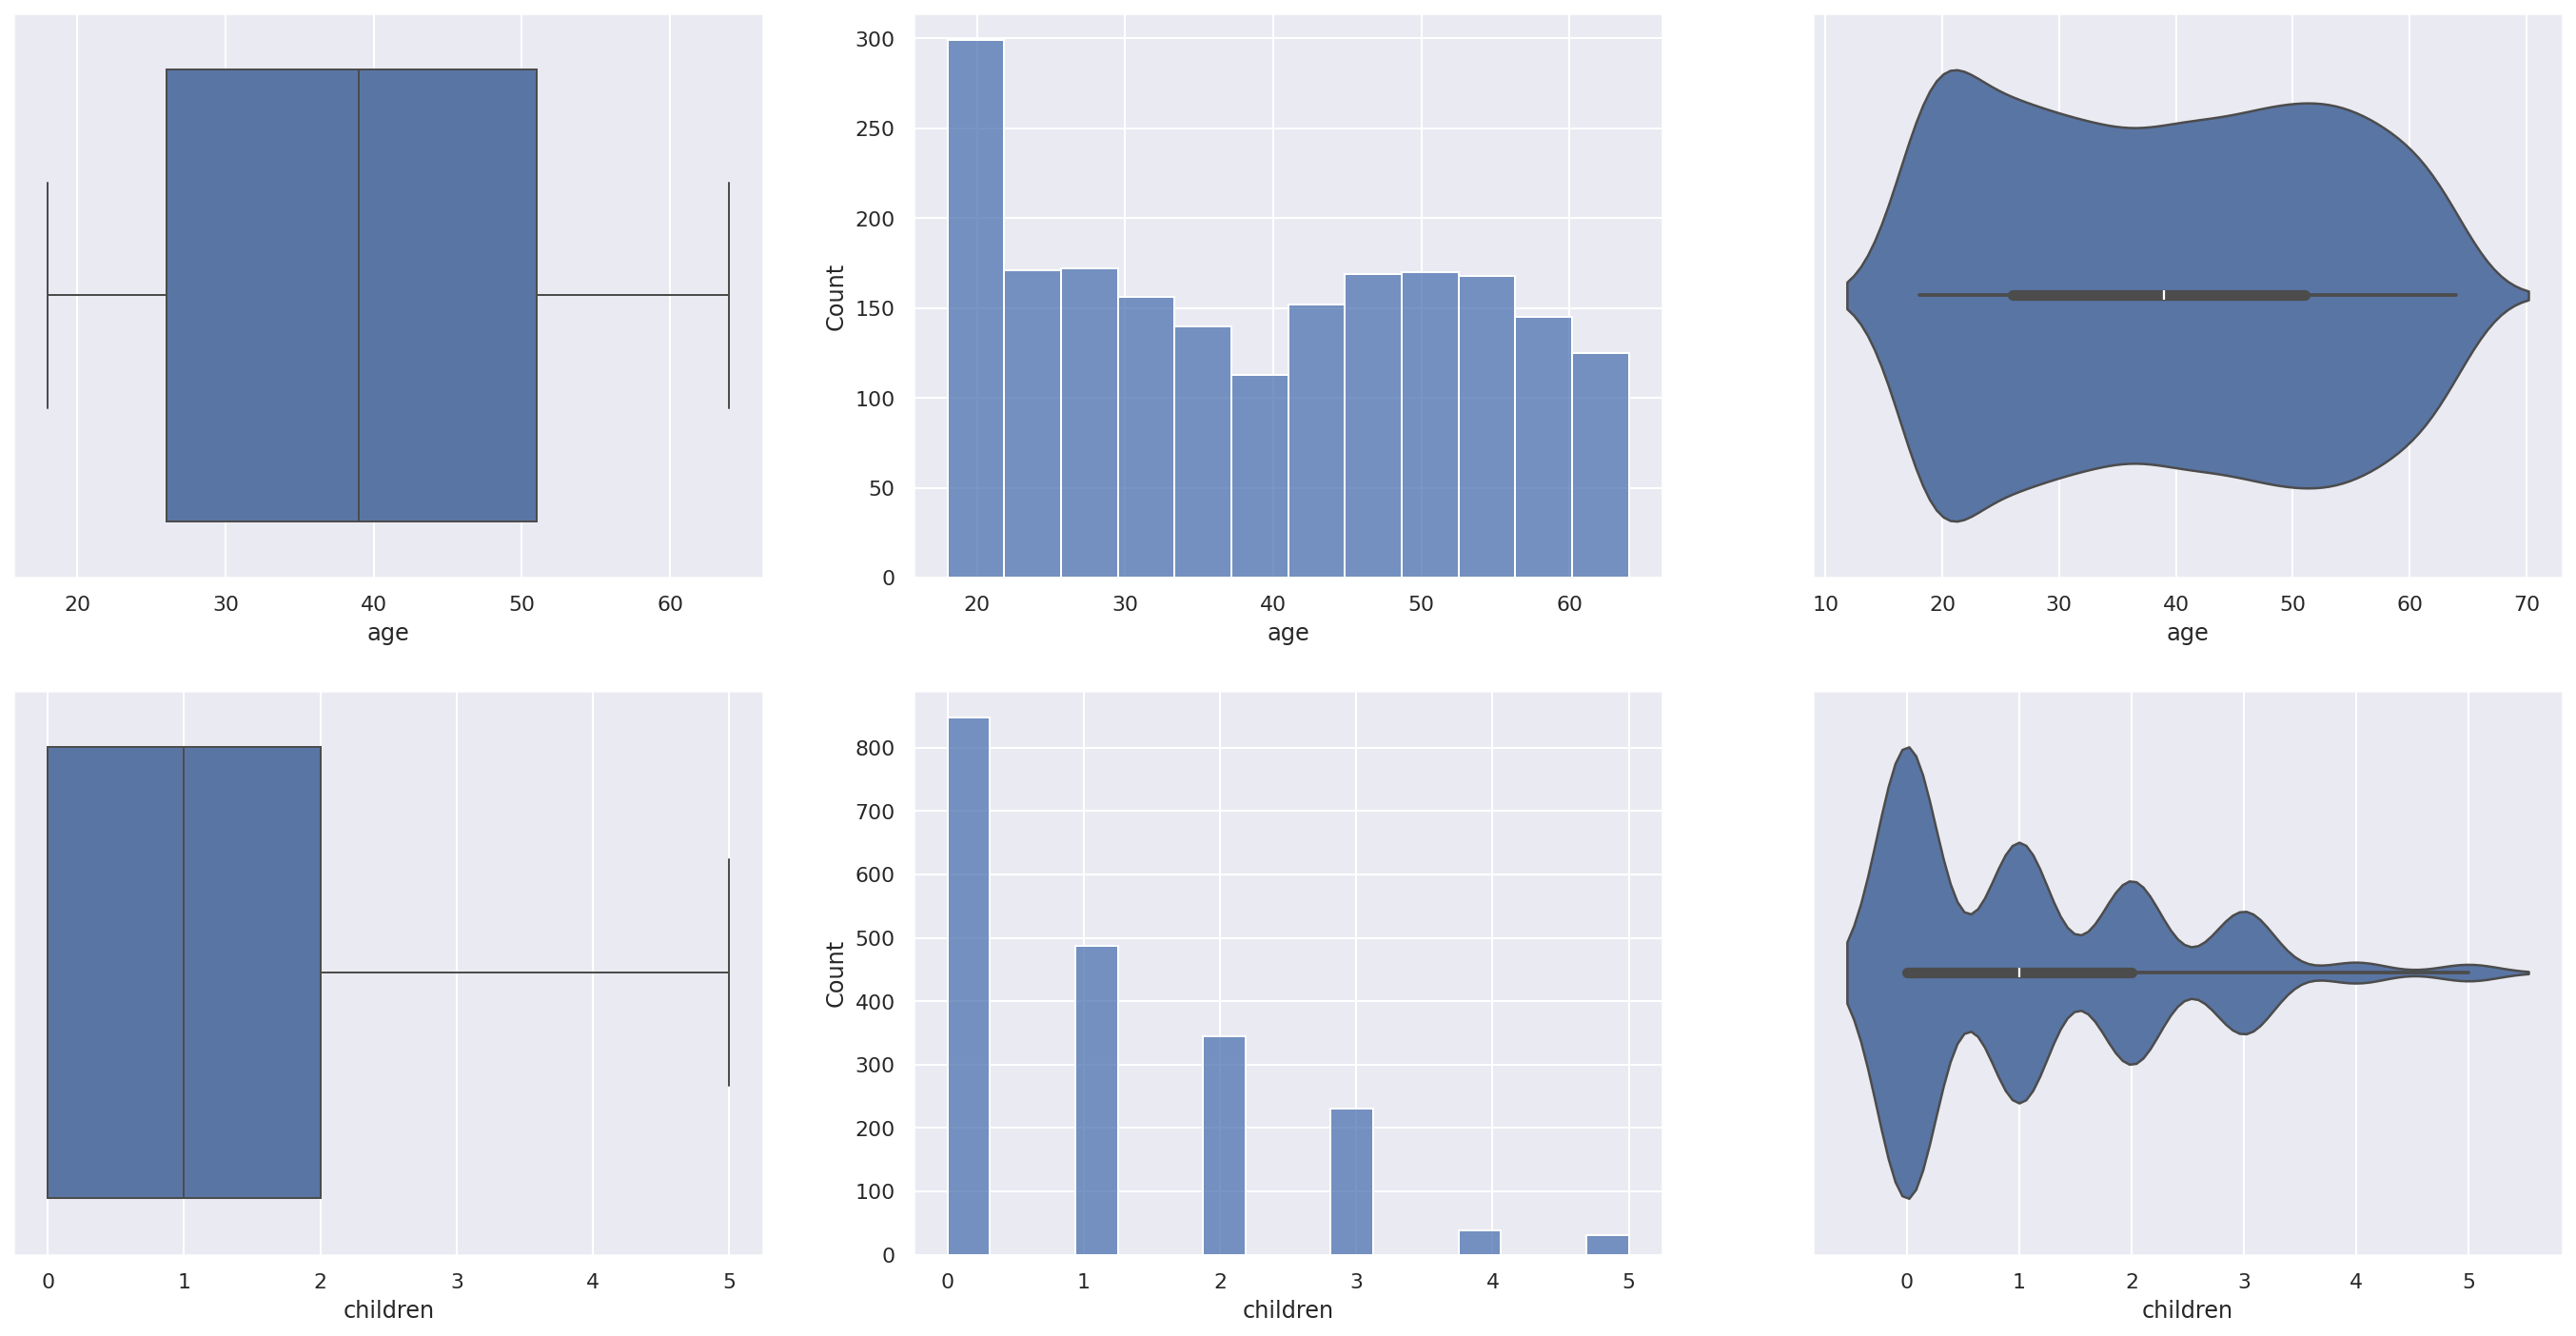

In [ ]:
# With seed
seed_value = 42
np.random.seed(seed_value)

X_2 = pd.DataFrame(medIn_cleaned[['age','children']])
y_2 = pd.DataFrame(medIn_cleaned['charges'])

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=seed_value)

# Visualize the distribution of the predictor variables

f, axes = plt.subplots(2, 3, figsize=(24, 12))

count = 0
for var in X_train_2:
    sb.boxplot(data = X_train_2[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = X_train_2[var], ax = axes[count,1])
    sb.violinplot(data = X_train_2[var], orient = "h", ax = axes[count,2])
    count += 1

<Axes: >

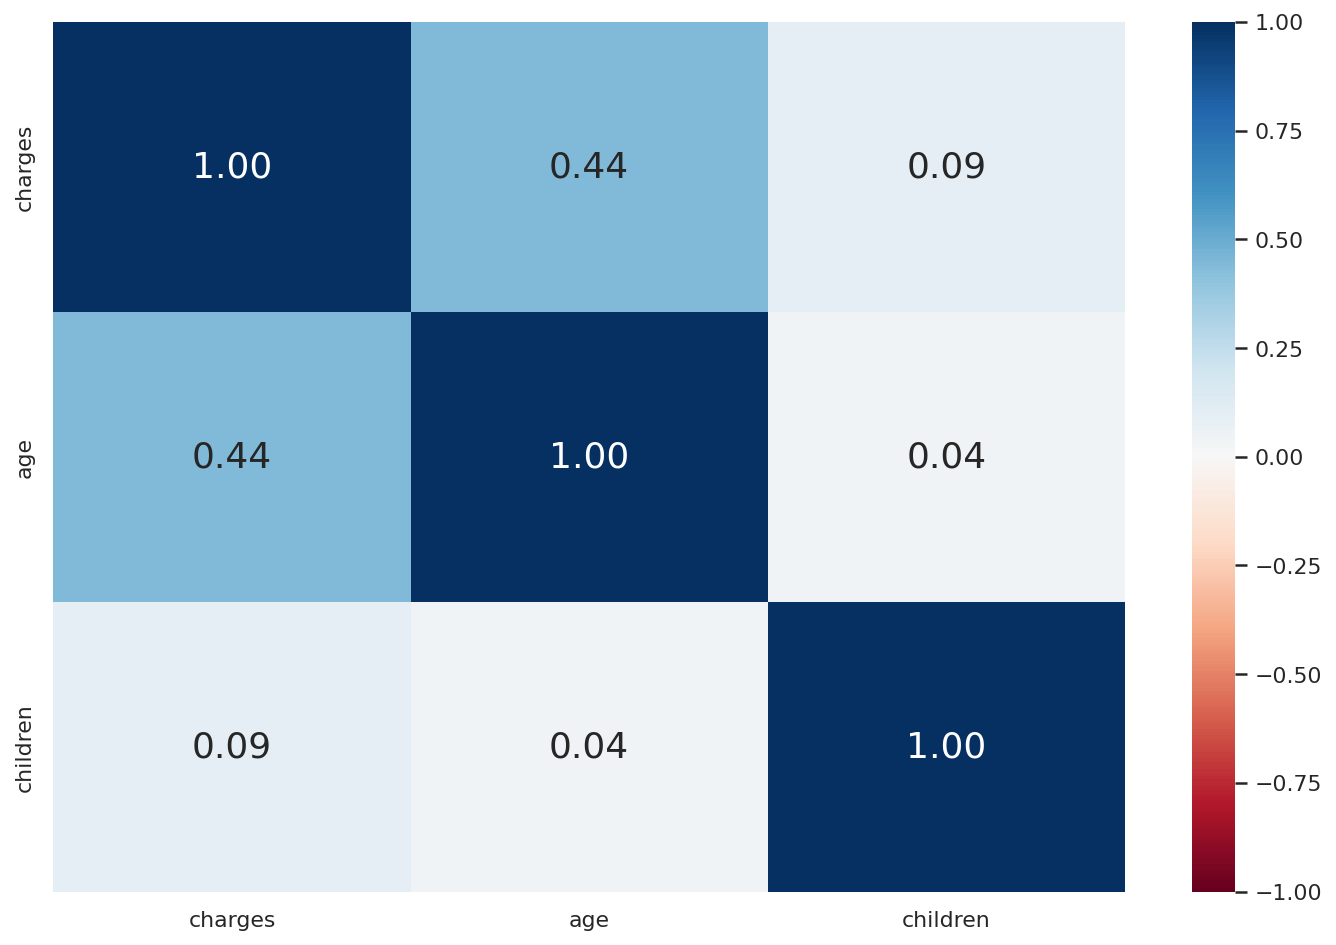

In [ ]:
# Correlation between Response and the Predictors
trainDF_2 = pd.concat([y_train_2, X_train_2], axis = 1).reindex(y_train_2.index)

f = plt.figure(figsize=(12, 8))
sb.heatmap(trainDF_2.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f",
           annot_kws = {"size" : 18}, cmap = "RdBu")

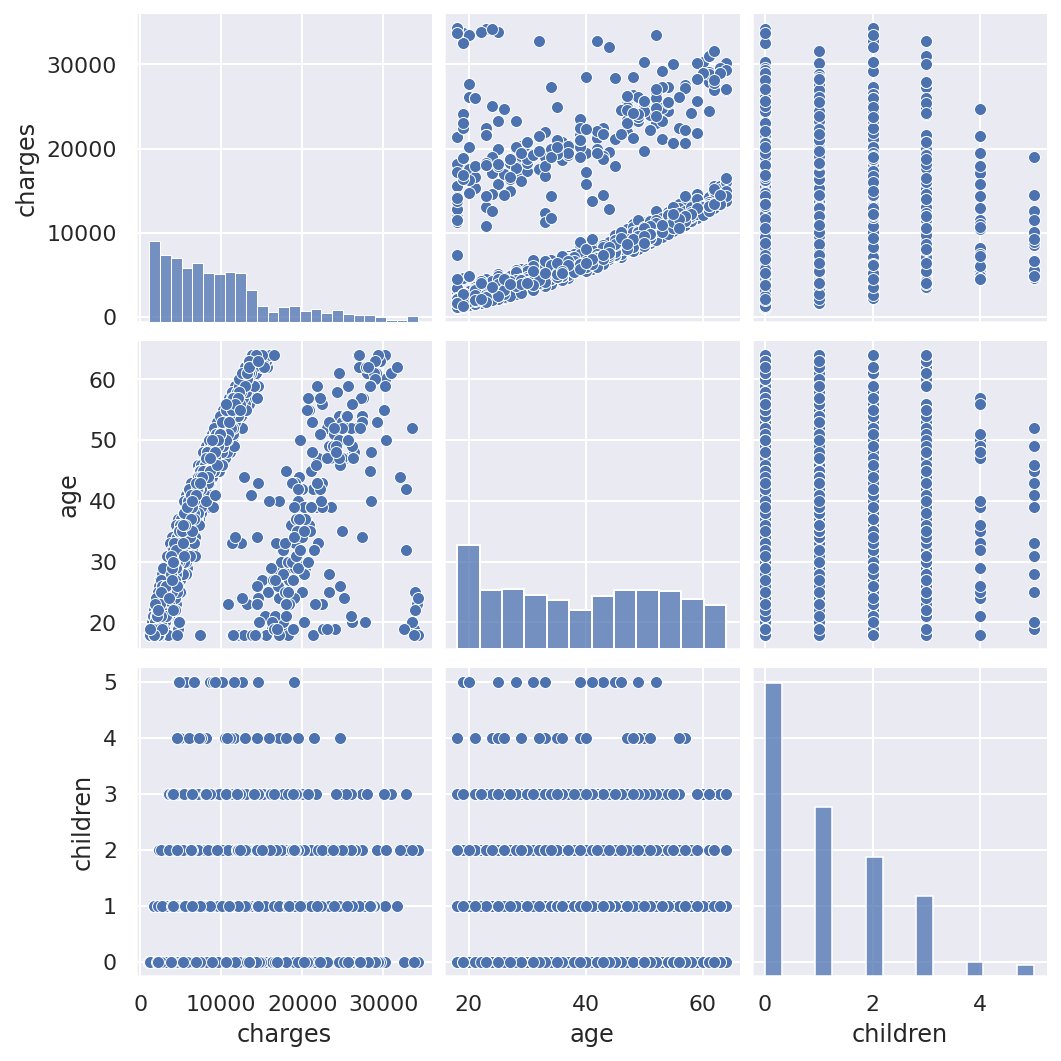

In [ ]:
sb.pairplot(data = trainDF_2)

In [ ]:
# Linear Regression using Train Data
linreg_2 = LinearRegression()         # create the linear regression object
linreg_2.fit(X_train_2, y_train_2)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg_2.intercept_)
print('Coefficients of Regression \t: a = ', linreg_2.coef_)
print()

# Print the Coefficients against Predictors
pd.DataFrame(list(zip(X_train_2.columns, linreg_2.coef_[0])), columns = ["Predictors", "Coefficients"])

Intercept of Regression 	: b =  [609.28184623]
Coefficients of Regression 	: a =  [[225.22520994 456.16358631]]



Predictors  Coefficients
0        age    225.225210
1   children    456.163586

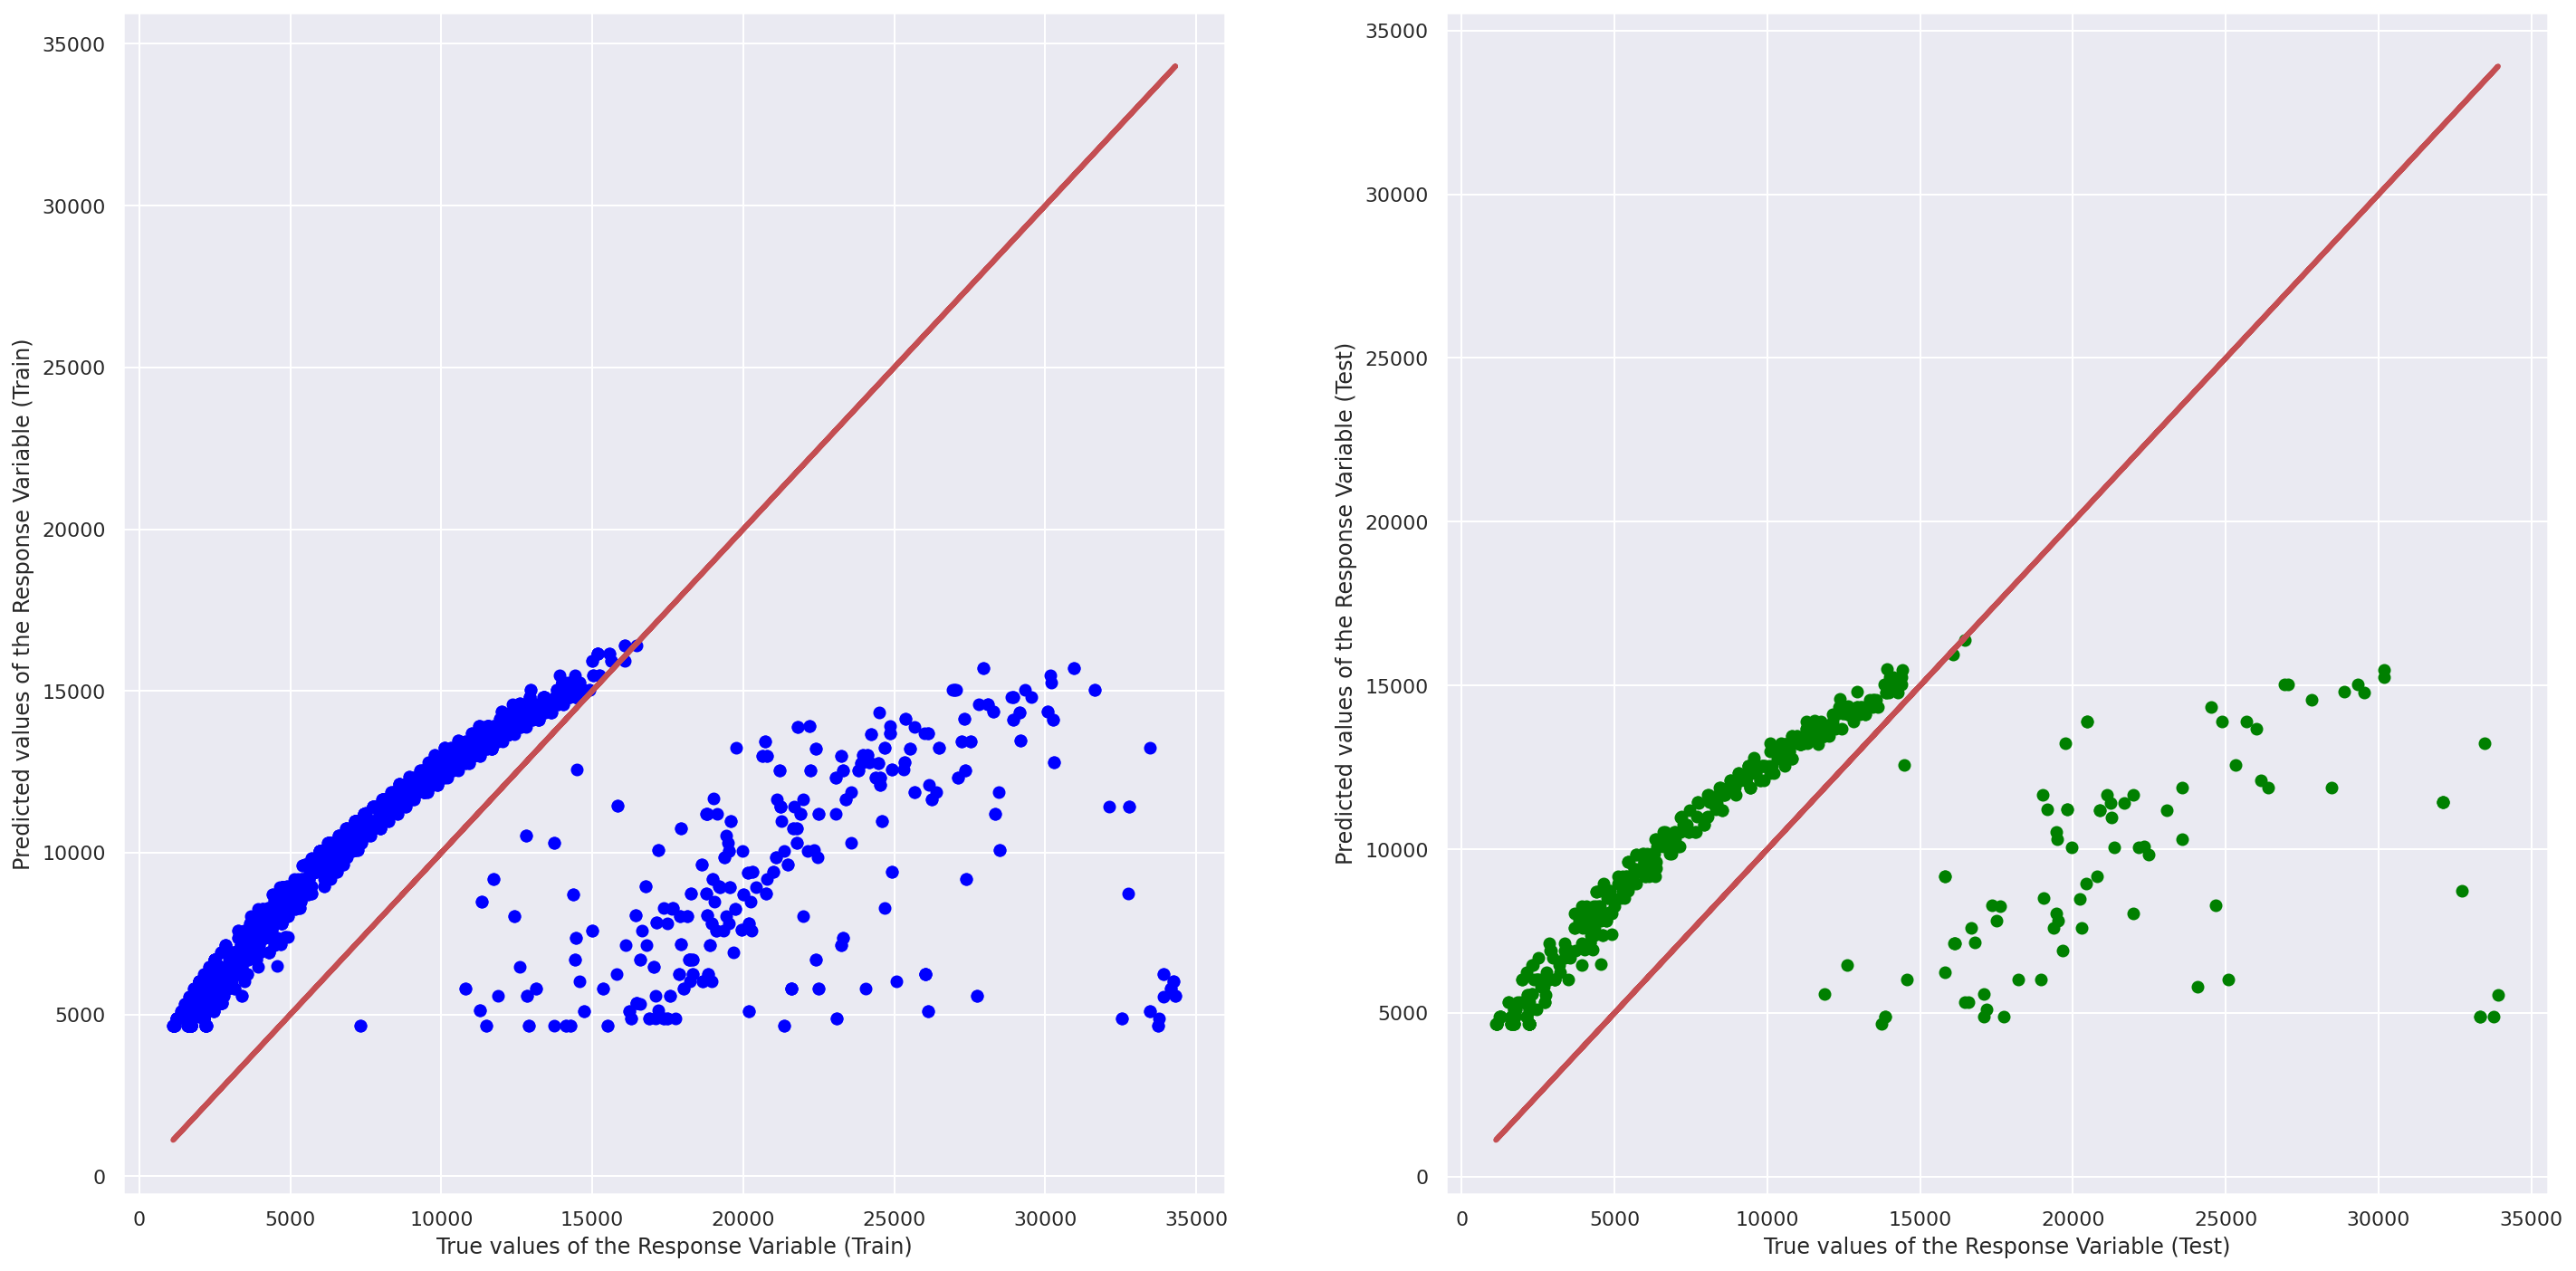

In [ ]:
# Predict the Total values from Predictors
y_train_pred_2 = linreg_2.predict(X_train_2)
y_test_pred_2 = linreg_2.predict(X_test_2)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train_2, y_train_pred_2, color = "blue")
axes[0].plot(y_train_2, y_train_2, 'r-', linewidth = 3)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test_2, y_test_pred_2, color = "green")
axes[1].plot(y_test_2, y_test_2, 'r-', linewidth = 3)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()



In [ ]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg_2.score(X_train_2, y_train_2))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train_2, y_train_pred_2))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg_2.score(X_test_2, y_test_2))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test_2, y_test_pred_2))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.2031960209513366
Mean Squared Error (MSE) 	: 41126915.7464807

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.2210939029309522
Mean Squared Error (MSE) 	: 39014203.191019304



#### Age and children - dataset separated into smoker and non smoker

**Non\-smoker**



In [ ]:
medIn_cleaned_smoker = medIn_cleaned[medIn_cleaned['smoker'] == 'yes']
medIn_cleaned_nonsmoker = medIn_cleaned[medIn_cleaned['smoker'] == 'no']

In [ ]:
X_3 = pd.DataFrame(medIn_cleaned_nonsmoker[['age', 'children']])
y_3 = pd.DataFrame(medIn_cleaned_nonsmoker['charges'])

X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=0.2, random_state=seed_value)

<Axes: >

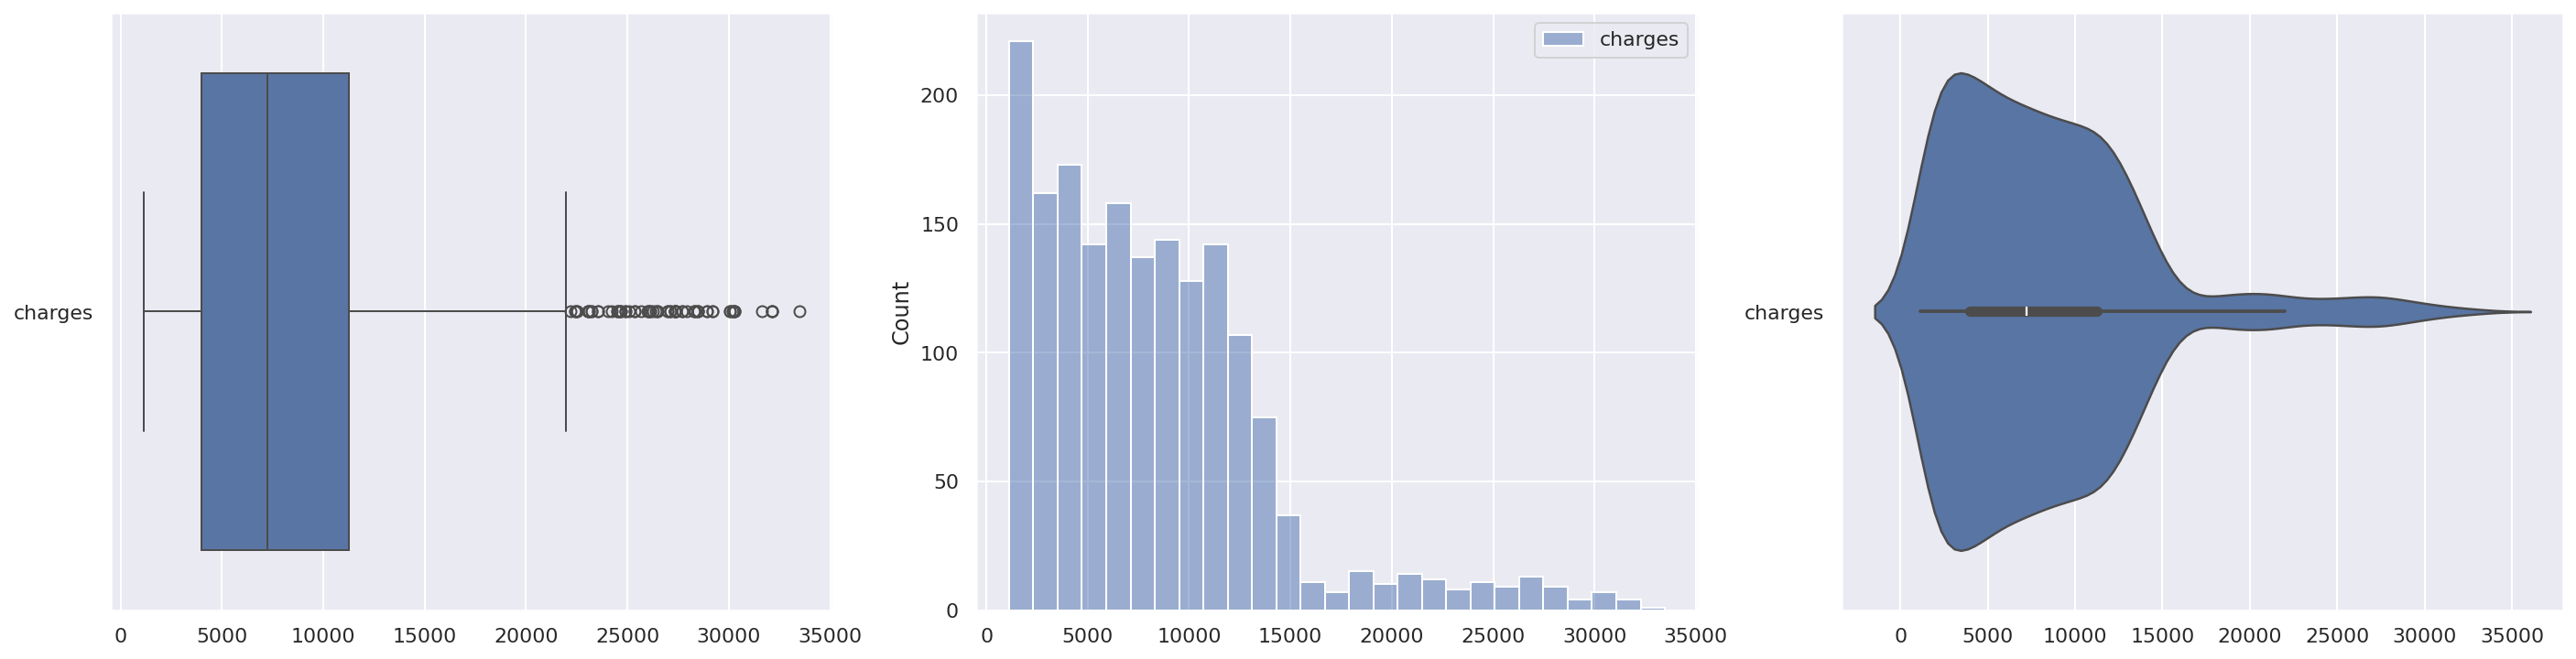

In [ ]:
# Visualize the distribution of the target variable

f, axes = plt.subplots(1, 3, figsize=(24, 6))
sb.boxplot(data = y_3_train, orient = "h", ax = axes[0])
sb.histplot(data = y_3_train, ax = axes[1])
sb.violinplot(data = y_3_train, orient = "h", ax = axes[2])

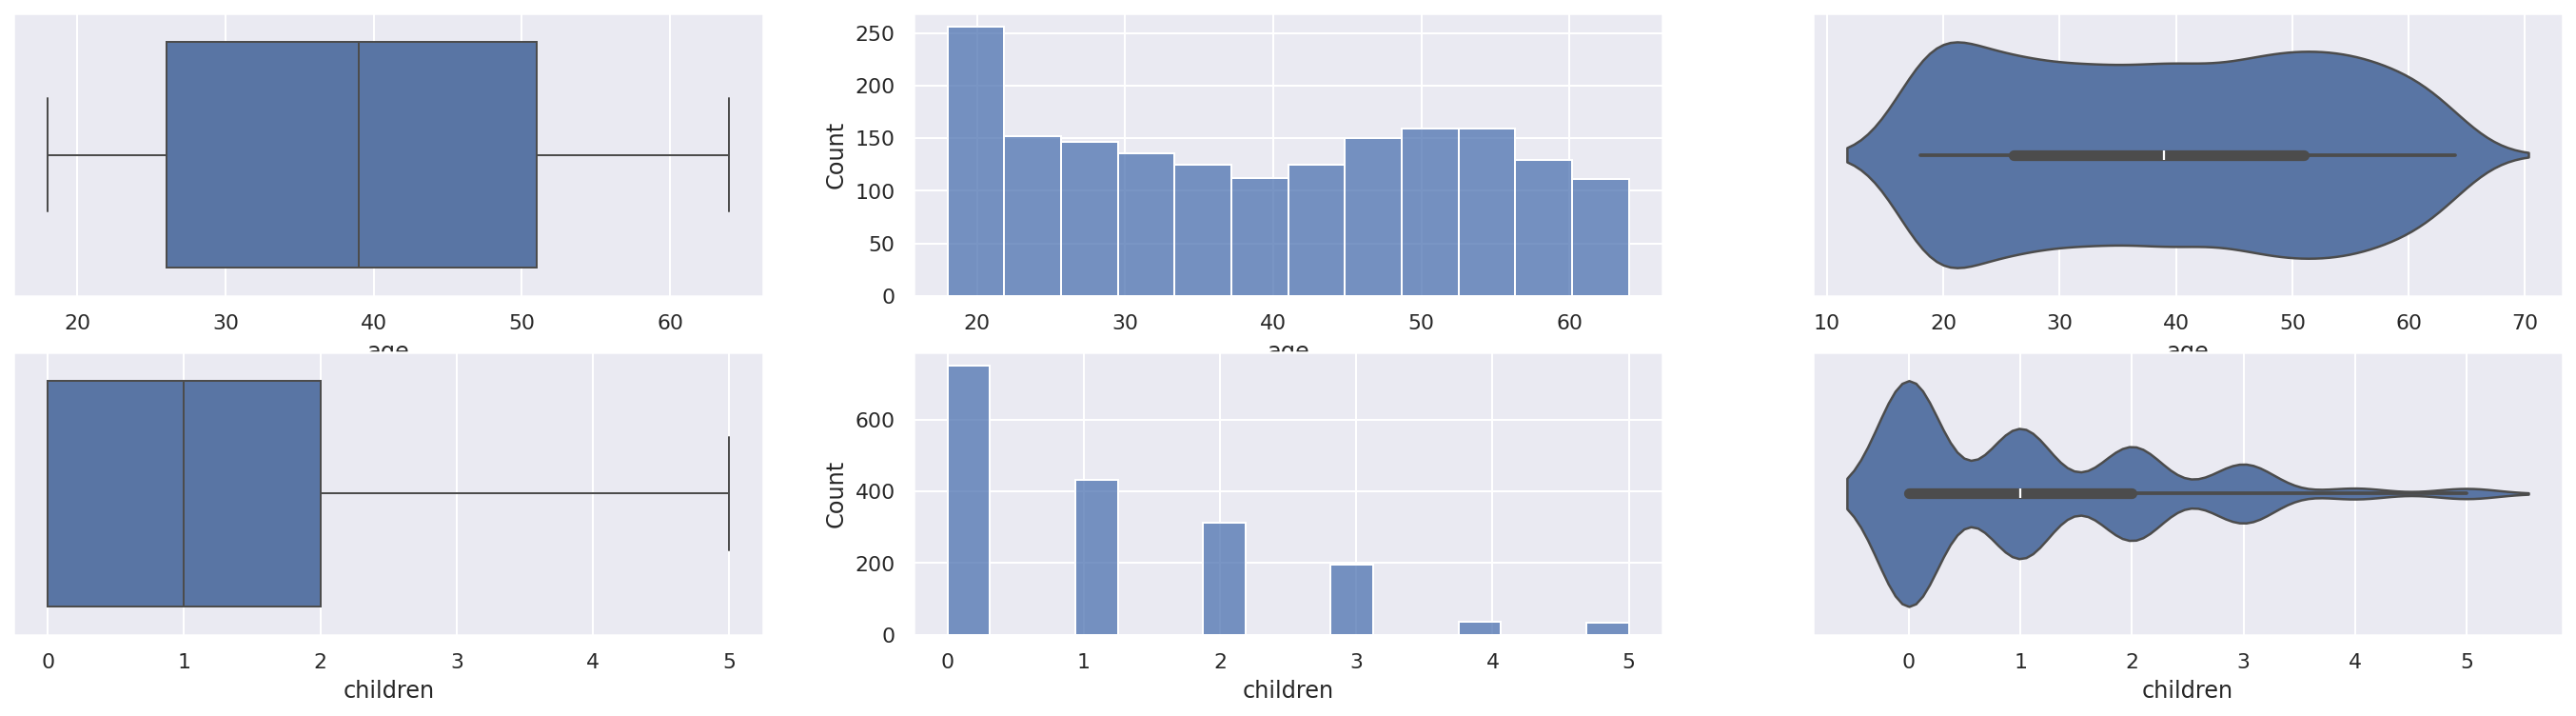

In [ ]:
# Visualize the distribution of the predictor variables

f, axes = plt.subplots(2, 3, figsize=(24, 6))

count = 0
for var in X_3_train:
    sb.boxplot(data = X_3_train[var], orient = "h", ax = axes[count, 0])
    sb.histplot(data = X_3_train[var], ax = axes[count, 1])
    sb.violinplot(data = X_3_train[var], orient = "h", ax = axes[count, 2])
    count += 1

<Axes: >

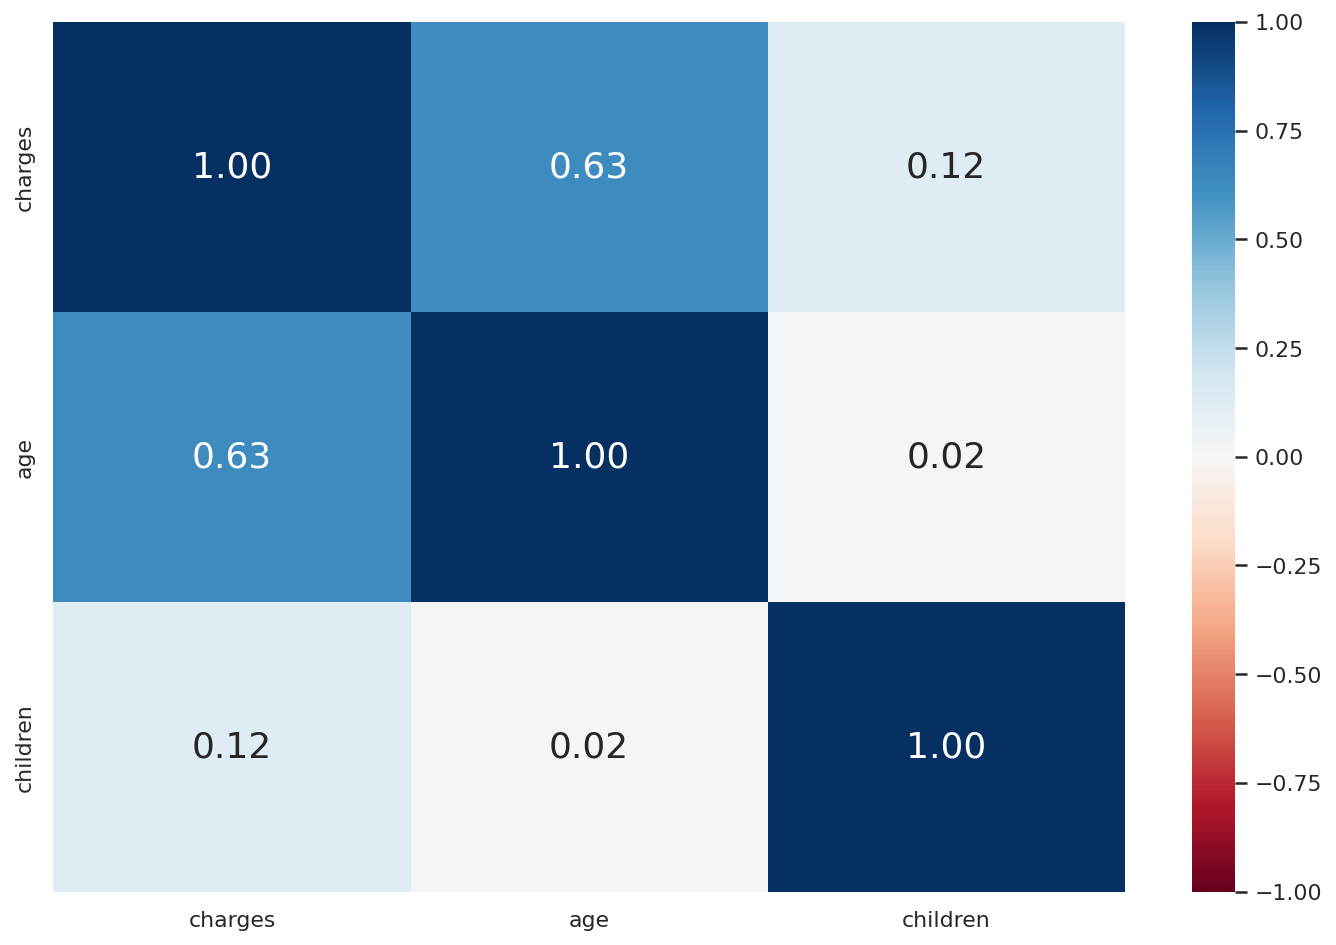

In [ ]:
# Correlation between Response and the Predictors
trainDF_3 = pd.concat([y_3_train, X_3_train], axis = 1).reindex(y_3_train.index)

f = plt.figure(figsize=(12, 8))
sb.heatmap(trainDF_3.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f",
           annot_kws = {"size" : 18}, cmap = "RdBu")

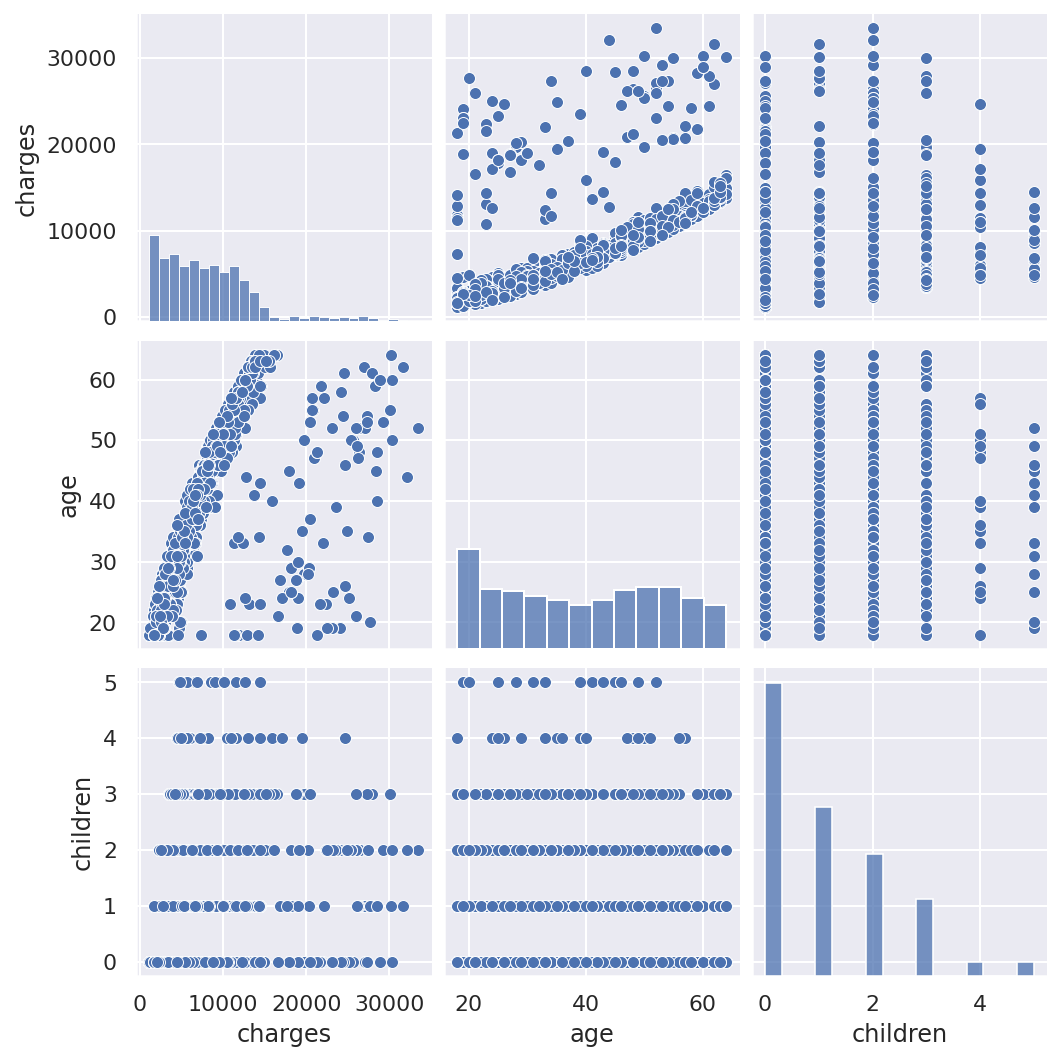

In [ ]:
sb.pairplot(data = trainDF_3)

In [ ]:
# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_3_train, y_3_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"])

Intercept of Regression 	: b =  [-2364.18025471]
Coefficients of Regression 	: a =  [[257.06302094 523.48565469]]



Predictors  Coefficients
0        age    257.063021

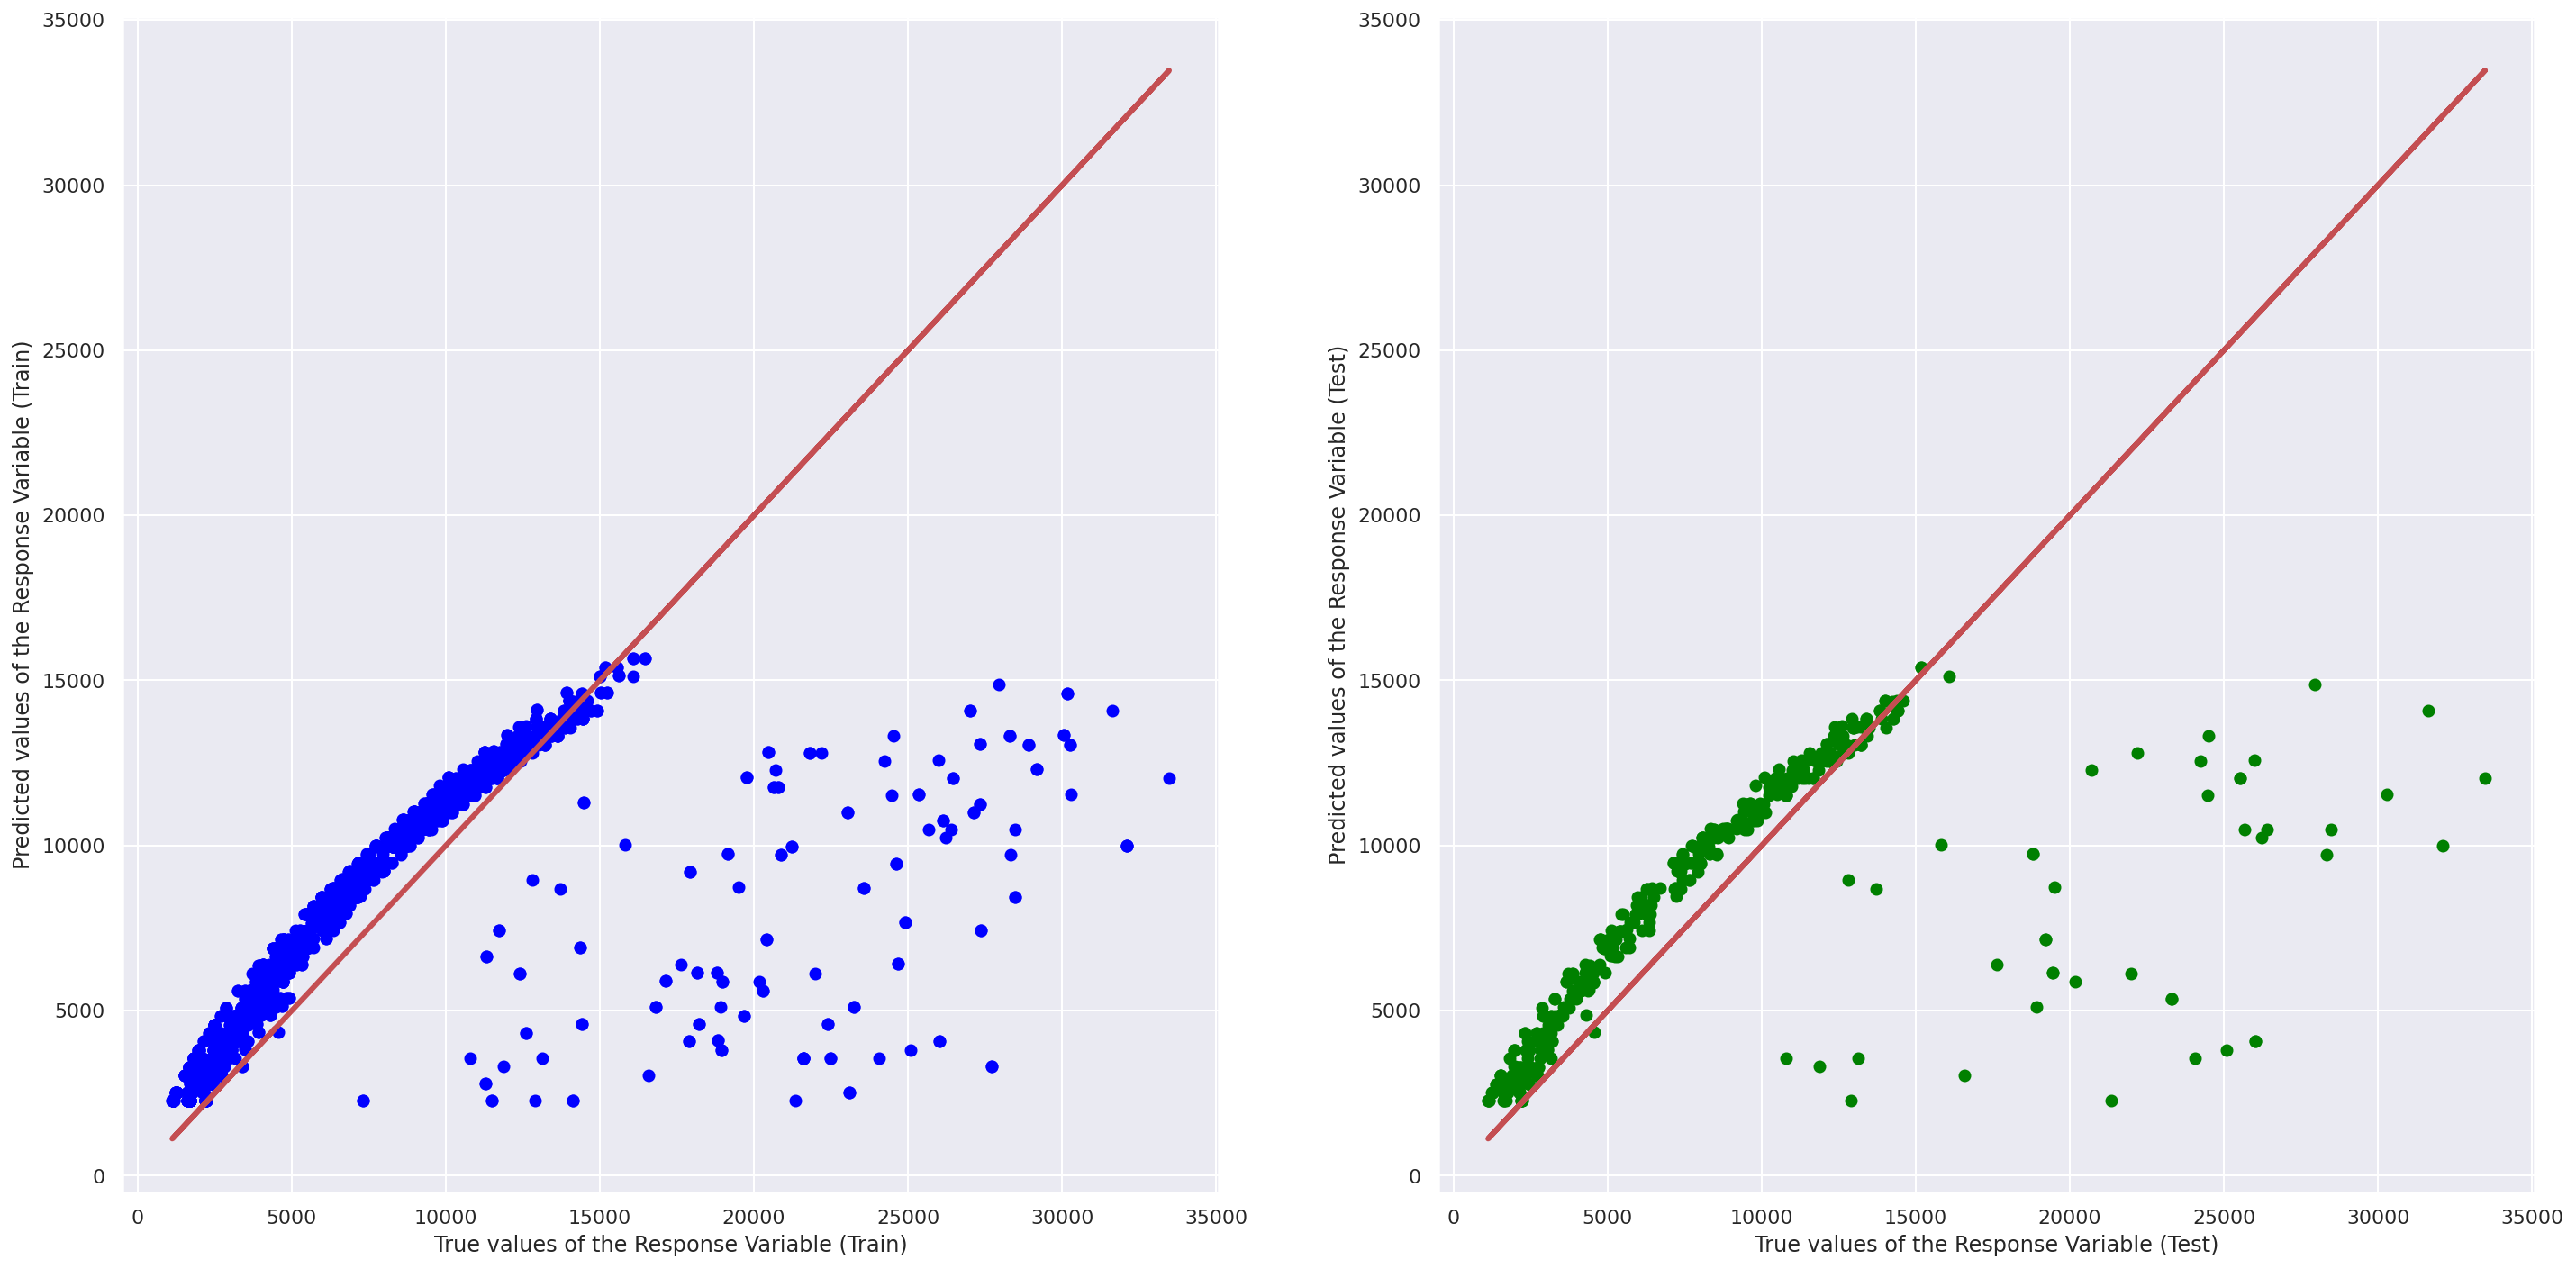

In [ ]:
# Predict the Total values from Predictors
y_3_train_pred = linreg.predict(X_3_train)
y_3_test_pred = linreg.predict(X_3_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_3_train, y_3_train_pred, color = "blue")
axes[0].plot(y_3_train, y_3_train, 'r-', linewidth = 3)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_3_test, y_3_test_pred, color = "green")
axes[1].plot(y_3_test, y_3_test, 'r-', linewidth = 3)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [ ]:
# Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_3_train, y_3_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_3_train, y_3_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_3_test, y_3_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_3_test, y_3_test_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.406705386121441
Mean Squared Error (MSE) 	: 19736050.45795305

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.382883587614661
Mean Squared Error (MSE) 	: 23238848.985130493



<span style='font-size:x-large'>Smokers</span>  



In [ ]:
X_4 = pd.DataFrame(medIn_cleaned_smoker[['age', 'children']])
y_4 = pd.DataFrame(medIn_cleaned_smoker['charges'])

X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4, y_4, test_size=0.2, random_state=seed_value)

<Axes: >

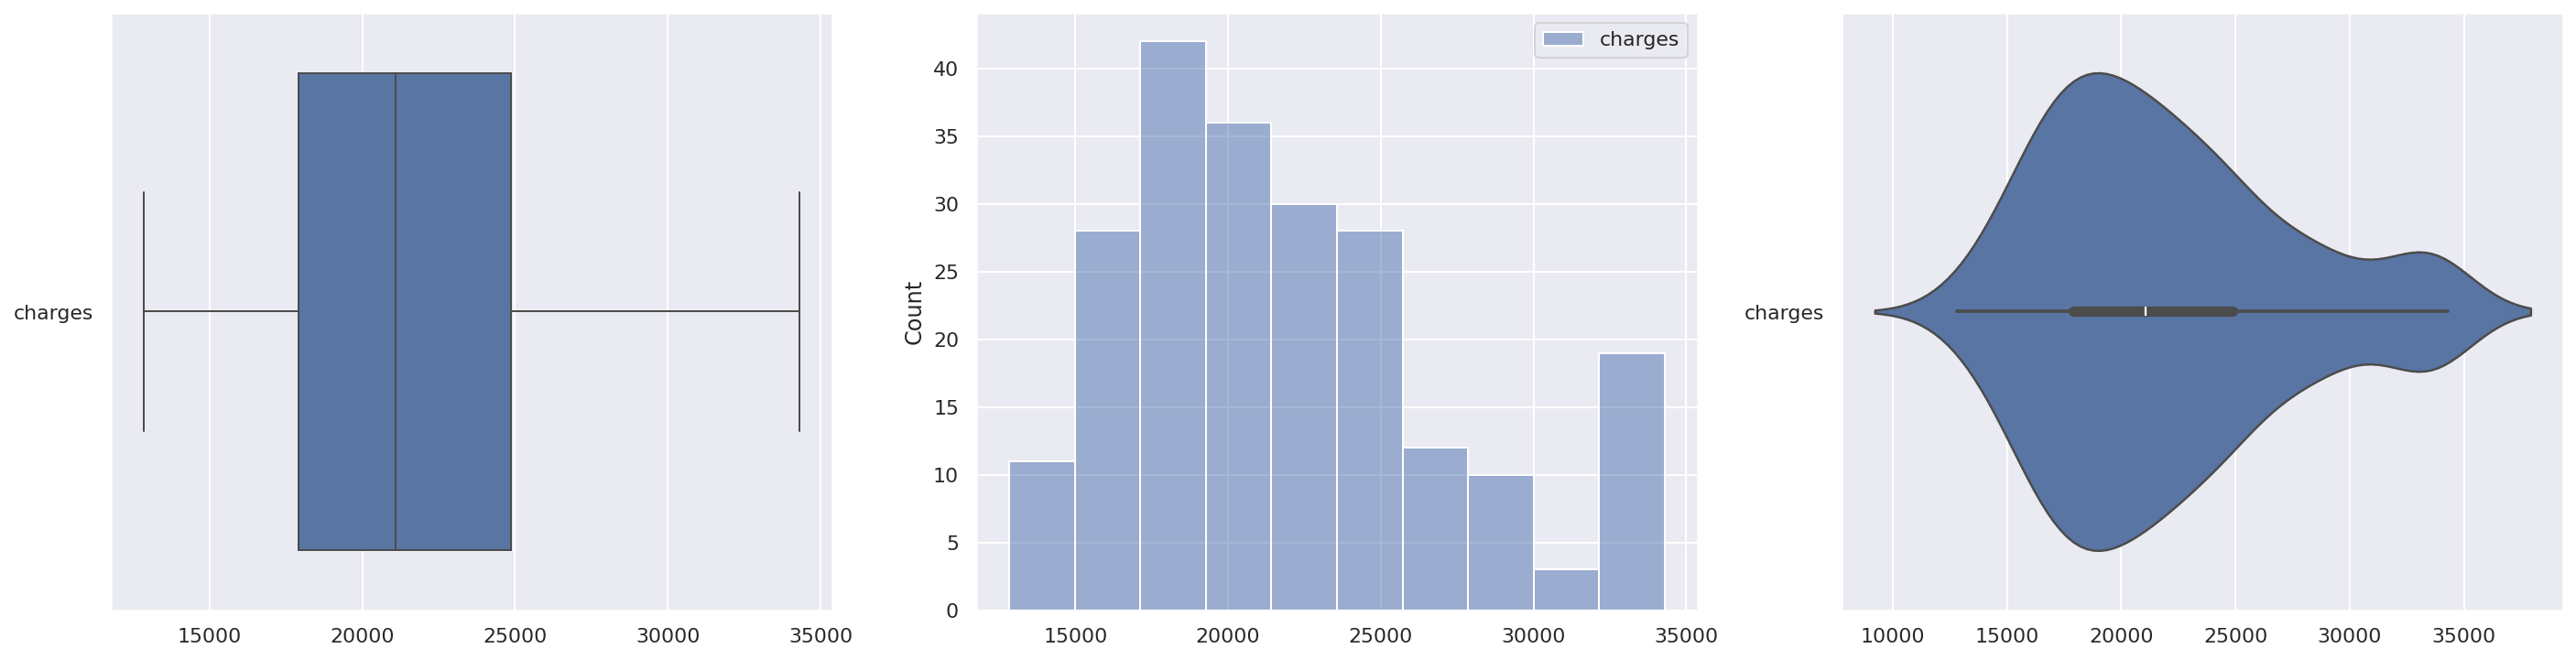

In [ ]:
# Visualize the distribution of the target variable

f, axes = plt.subplots(1, 3, figsize=(24, 6))
sb.boxplot(data = y_4_train, orient = "h", ax = axes[0])
sb.histplot(data = y_4_train, ax = axes[1])
sb.violinplot(data = y_4_train, orient = "h", ax = axes[2])

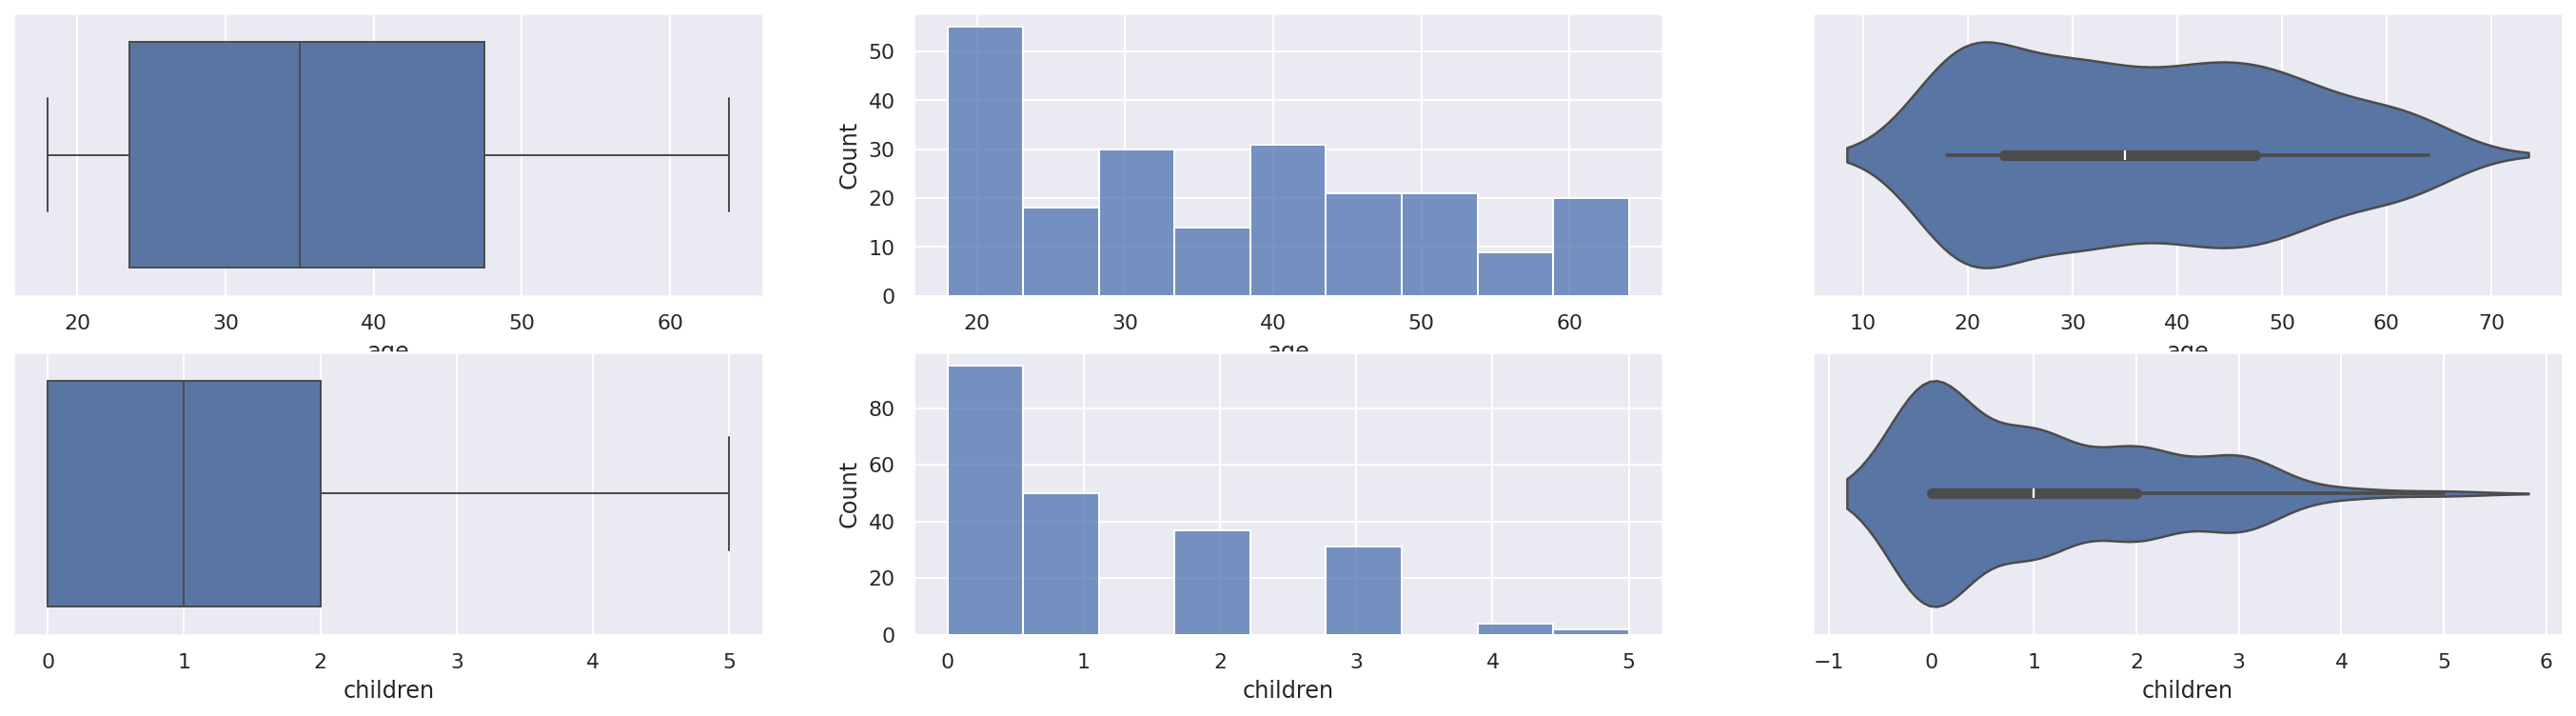

In [ ]:
# Visualize the distribution of the predictor variables

f, axes = plt.subplots(2, 3, figsize=(24, 6))

count = 0
for var in X_4_train:
    sb.boxplot(data = X_4_train[var], orient = "h", ax = axes[count, 0])
    sb.histplot(data = X_4_train[var], ax = axes[count, 1])
    sb.violinplot(data = X_4_train[var], orient = "h", ax = axes[count, 2])
    count += 1

<Axes: >

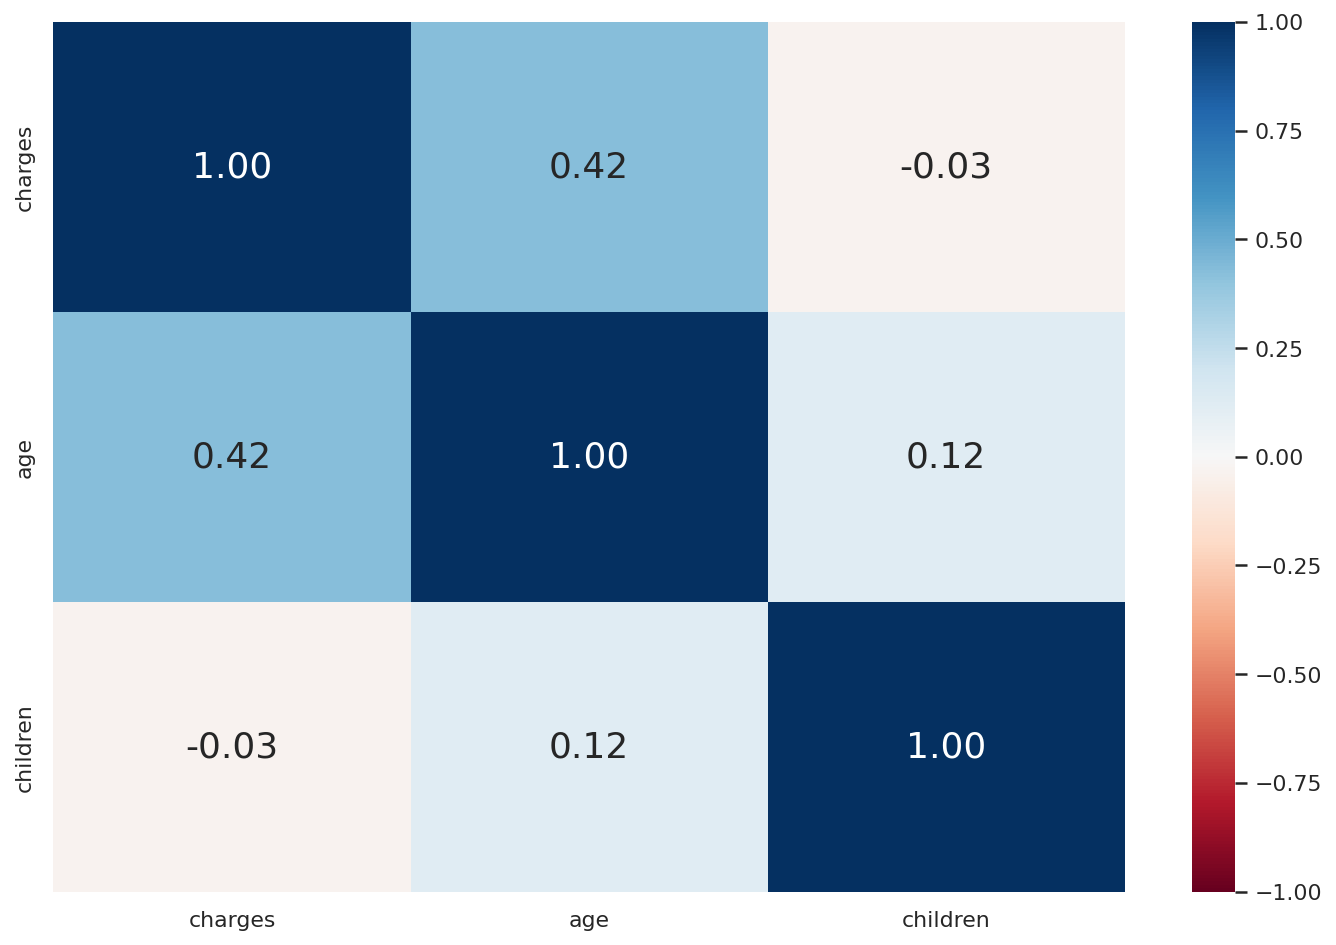

In [ ]:
# Correlation between Response and the Predictors
trainDF_4 = pd.concat([y_4_train, X_4_train], axis = 1).reindex(y_4_train.index)

f = plt.figure(figsize=(12, 8))
sb.heatmap(trainDF_4.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f",
           annot_kws = {"size" : 18}, cmap = "RdBu")

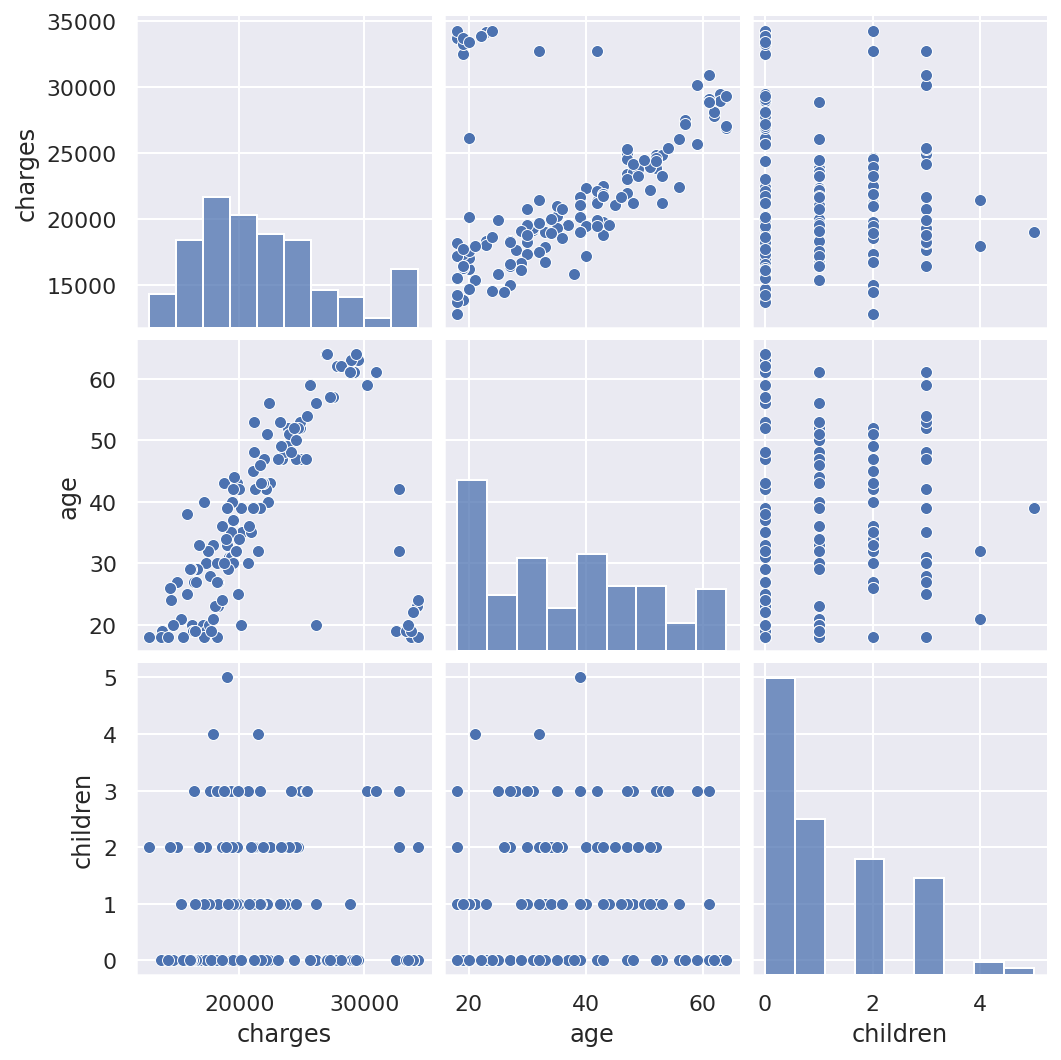

In [ ]:
sb.pairplot(data = trainDF_4)

In [ ]:
# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_4_train, y_4_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
pd.DataFrame(list(zip(X_4_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"])

Intercept of Regression 	: b =  [16320.05187163]
Coefficients of Regression 	: a =  [[ 163.65141054 -374.8642591 ]]



Predictors  Coefficients
0        age    163.651411
1   children   -374.864259

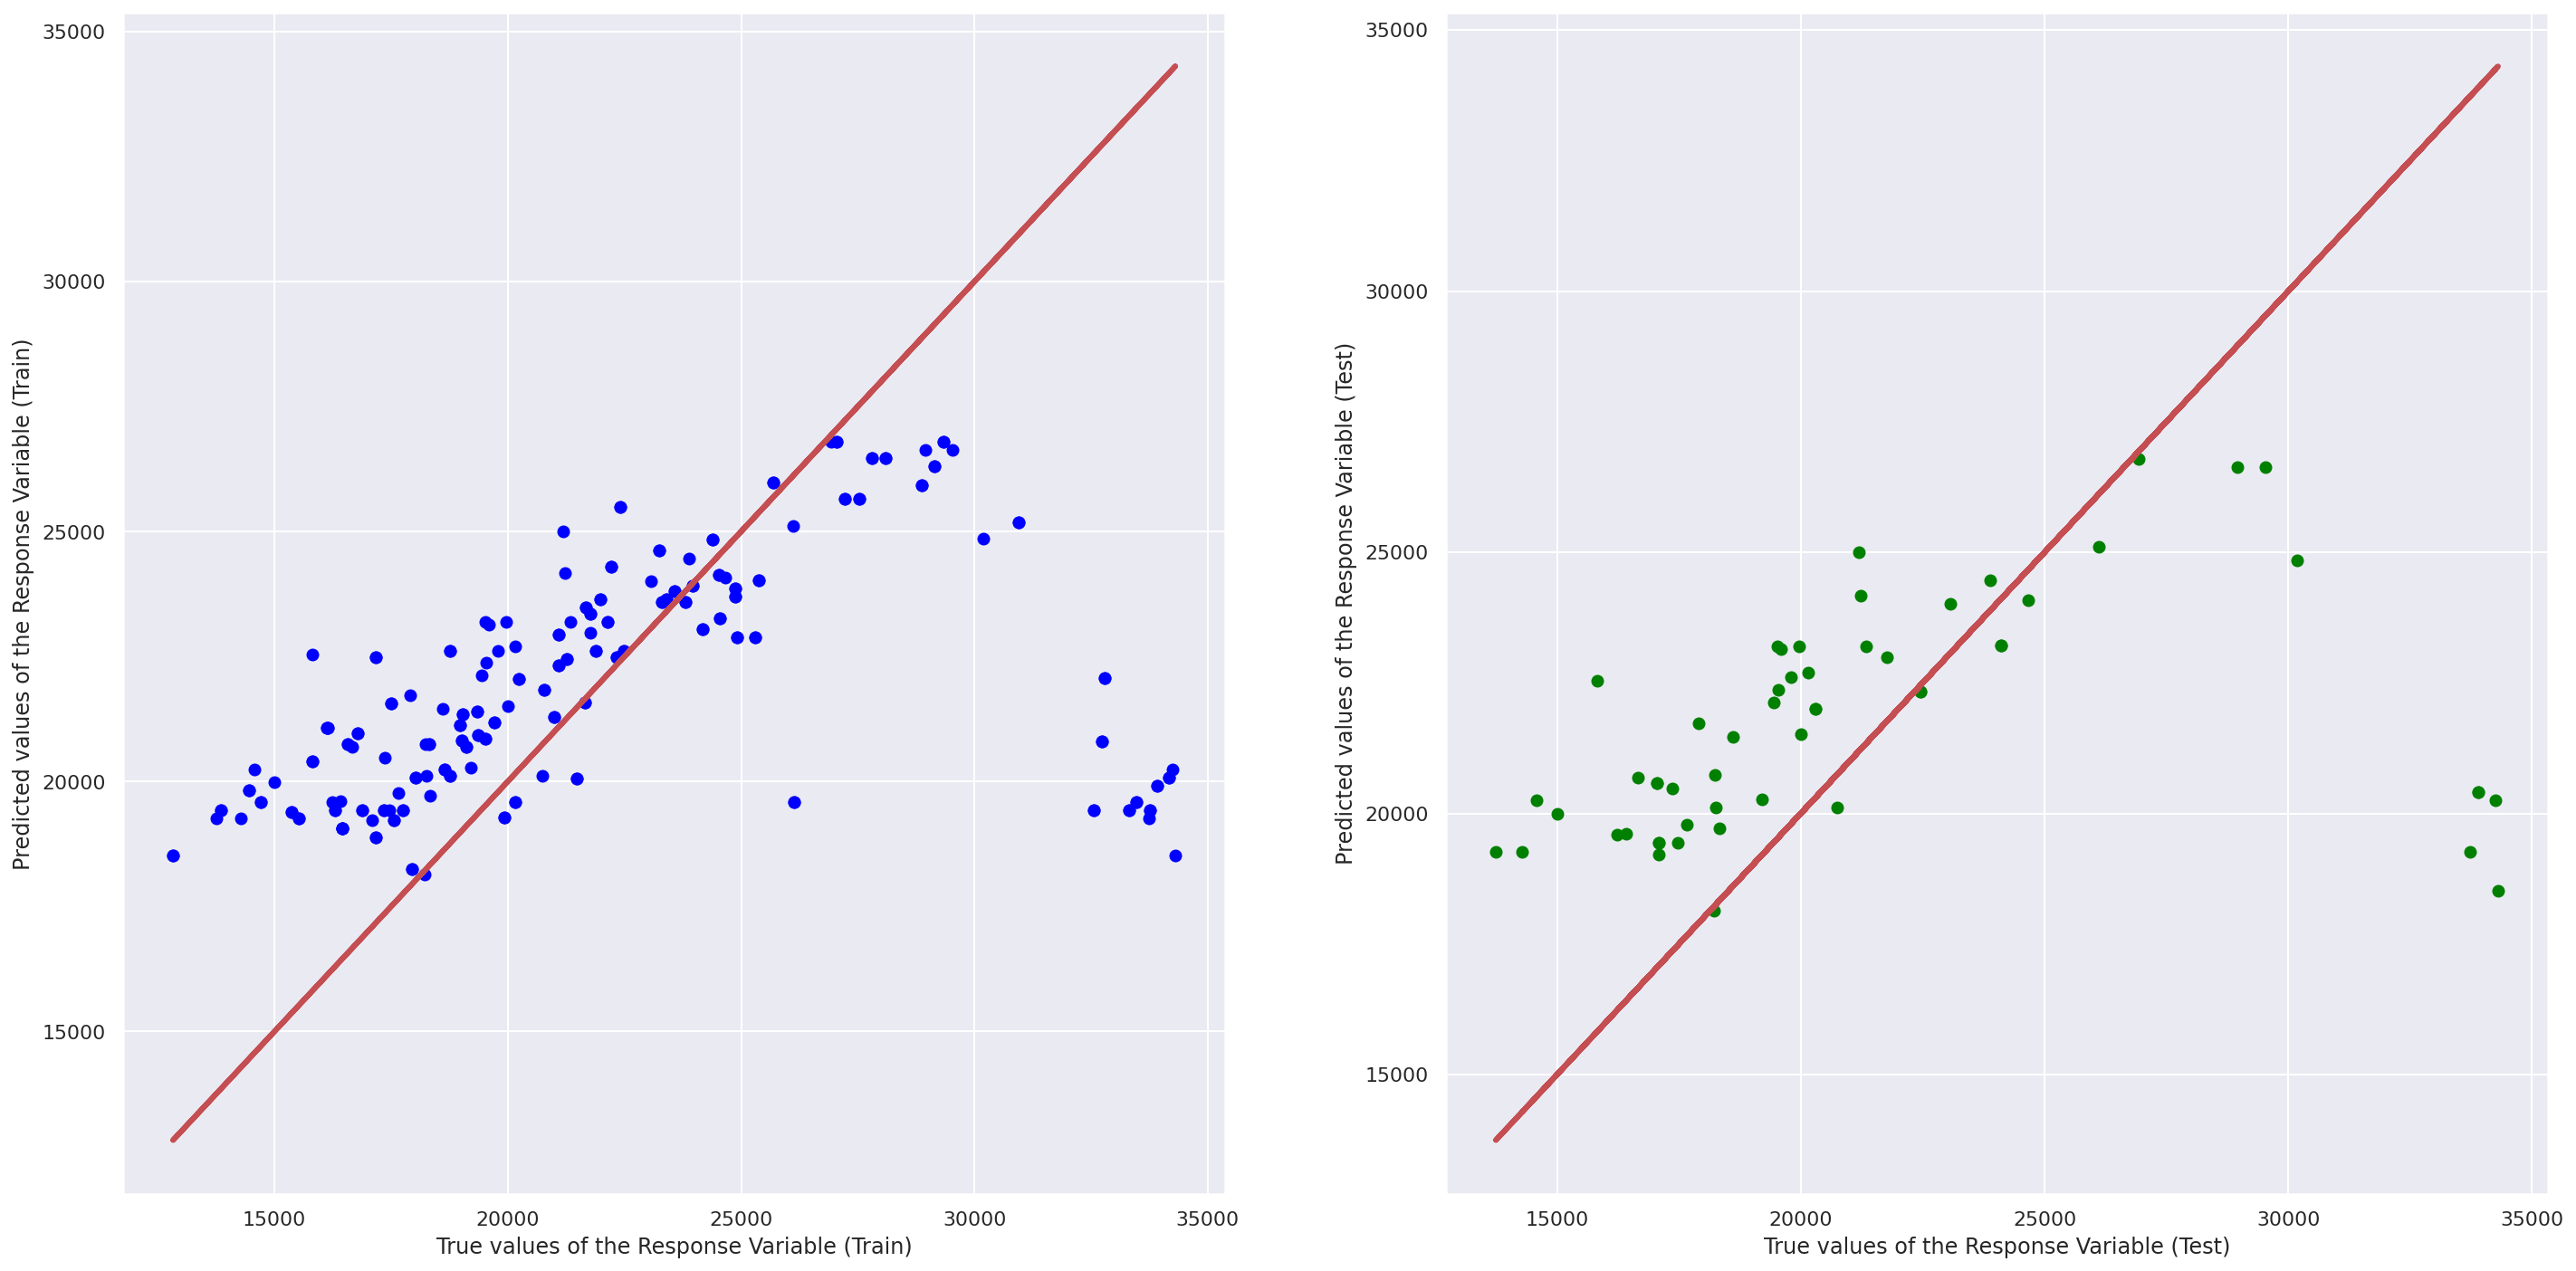

In [ ]:
# Predict the Total values from Predictors
y_4_train_pred = linreg.predict(X_4_train)
y_4_test_pred = linreg.predict(X_4_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_4_train, y_4_train_pred, color = "blue")
axes[0].plot(y_4_train, y_4_train, 'r-', linewidth = 3)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_4_test, y_4_test_pred, color = "green")
axes[1].plot(y_4_test, y_4_test, 'r-', linewidth = 3)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [ ]:
# Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_4_train, y_4_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_4_train, y_4_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_4_test, y_4_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_4_test, y_4_test_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.18535049521631708
Mean Squared Error (MSE) 	: 22823718.54336255

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.09850563277190638
Mean Squared Error (MSE) 	: 26487303.26548786



#### Polynomial Regression \- Age and Children



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Intercept for the Polynomial model =  [9062.29320563]
Coefficents for the Polynomial model =  [[   0.         3052.67126477 1129.67674779 1105.91880019  -46.15154634
  -289.63456507]]



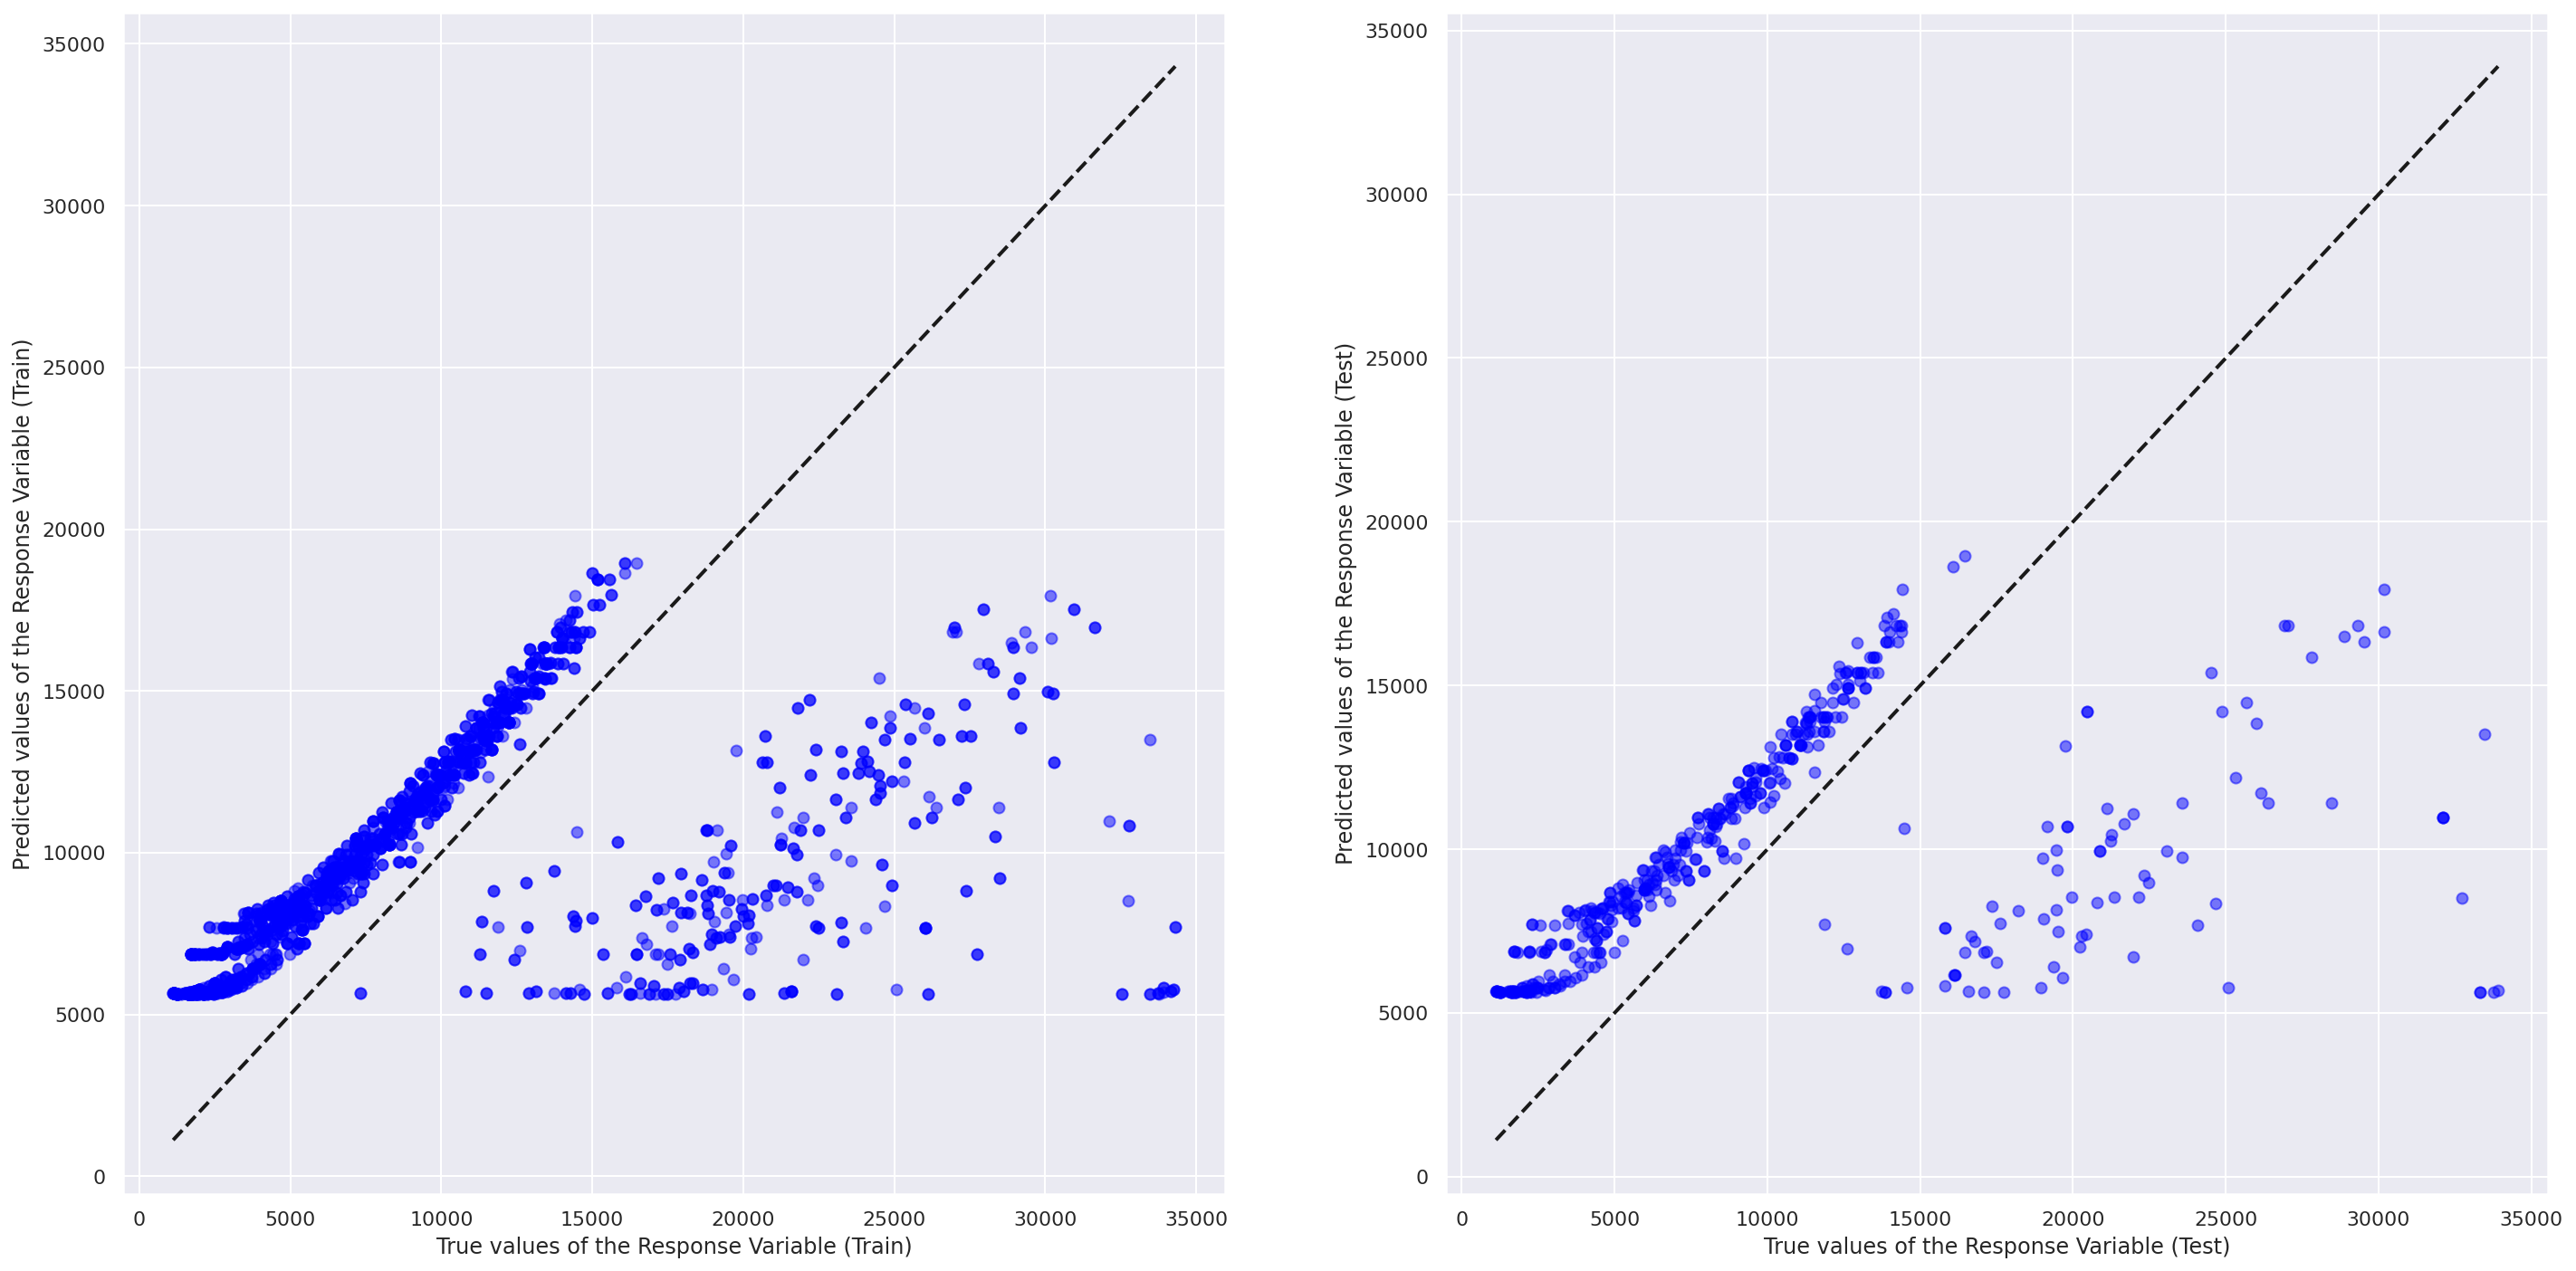

In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Regularization: Ridge regression
ridge_model = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)
ridge_model.fit(X_train_2, y_train_2)

# Regularization: Lasso regression
lasso_model = LassoCV(alphas=[0.1, 1.0, 10.0], cv=5)
lasso_model.fit(X_train_2, y_train_2)

# Cross-validation
ridge_cv_score = ridge_model.score(X_test_2, y_test_2)
lasso_cv_score = lasso_model.score(X_test_2, y_test_2)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2)
X_test_scaled = scaler.transform(X_test_2)

# Feature Engineering: Adding polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Linear Regression with polynomial features
linreg_poly = LinearRegression()
linreg_poly.fit(X_train_poly, y_train_2)

# Predictions on test data
y_test_poly_pred = linreg_poly.predict(X_test_poly)
y_train_poly_pred = linreg_poly.predict(X_train_poly)
from sklearn.linear_model import Ridge # used to calculate score of the model
ridgeReg = Ridge().fit(X_train_2,y_train_2)

print ("Intercept for the Polynomial model = ", linreg_poly.intercept_)
print ("Coefficents for the Polynomial model = ", linreg_poly.coef_)
print()

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train_2, y_train_poly_pred, color='blue', alpha=0.5)
axes[0].plot([y_train_2.min(), y_train_2.max()], [y_train_2.min(), y_train_2.max()], 'k--', lw=2)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test_2, y_test_poly_pred, color='blue', alpha=0.5)
axes[1].plot([y_test_2.min(), y_test_2.max()], [y_test_2.min(), y_test_2.max()], 'k--', lw=2)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [ ]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg_poly.score(X_train_poly,y_train_2))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train_2, y_train_poly_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg_poly.score(X_test_poly,y_test_2))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test_2, y_test_poly_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.2186343443929214
Mean Squared Error (MSE) 	: 40330069.038703166

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.21963622558325624
Mean Squared Error (MSE) 	: 39087215.99762584



<span style='font-size:medium'>The R^2 value has increased, from 0.2031960209513366 for the train dataset to 0.2186343443929214, and decreased from 0.2210939029309522 to 0.21963622558325624 for the test dataset. Thus, we observe that the polynomial regression provides a slightly more accurate prediction when predicting insurance costs based on age and children.</span>  



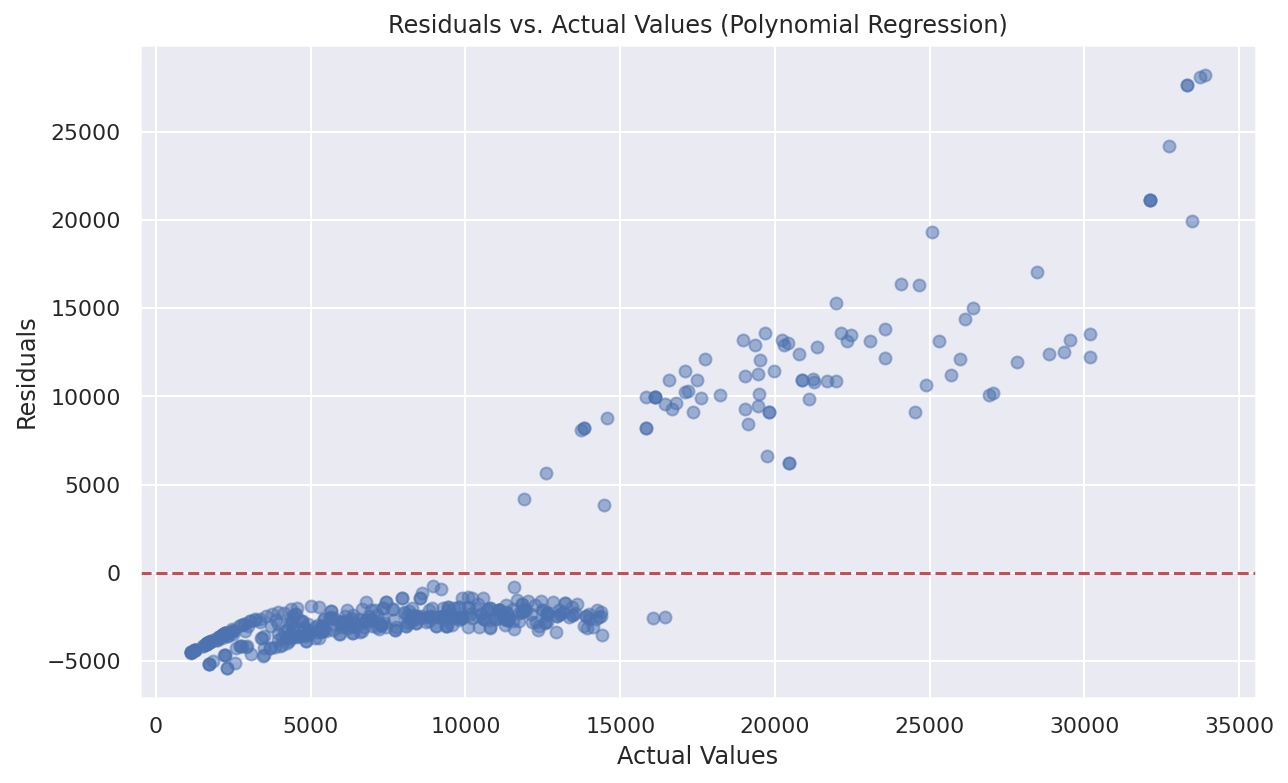

In [ ]:
# Model Evaluation
y_train_pred_poly = linreg_poly.predict(X_train_poly)
y_test_pred_poly = linreg_poly.predict(X_test_poly)
mse_train_poly = mean_squared_error(y_train_2, y_train_pred_poly)
mse_test_poly = mean_squared_error(y_test_2, y_test_pred_poly)
r2_train_poly = linreg_poly.score(X_train_poly, y_train_2)
r2_test_poly = linreg_poly.score(X_test_poly, y_test_2)

# Residual Analysis
residuals_poly = y_test_2 - y_test_pred_poly

# Visualizing residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test_2, residuals_poly, alpha=0.5)
plt.title('Residuals vs. Actual Values (Polynomial Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

<span style='font-size:medium'>The residuals in the lower range are clustered near the residual line \(i.e. residual = 0\), while residuals in the higher range deviate further from the residual line. This implies that the model predicts lower insurance costs more accurately, and becomes less accurate as it tries to predict higher insurance costs.</span>  



### Random Forest Regression


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train MSE: 39197496.9766225
Test MSE: 39385950.37120374
Train R^2: 0.24057710156897927
Test R^2: 0.21367208929564152


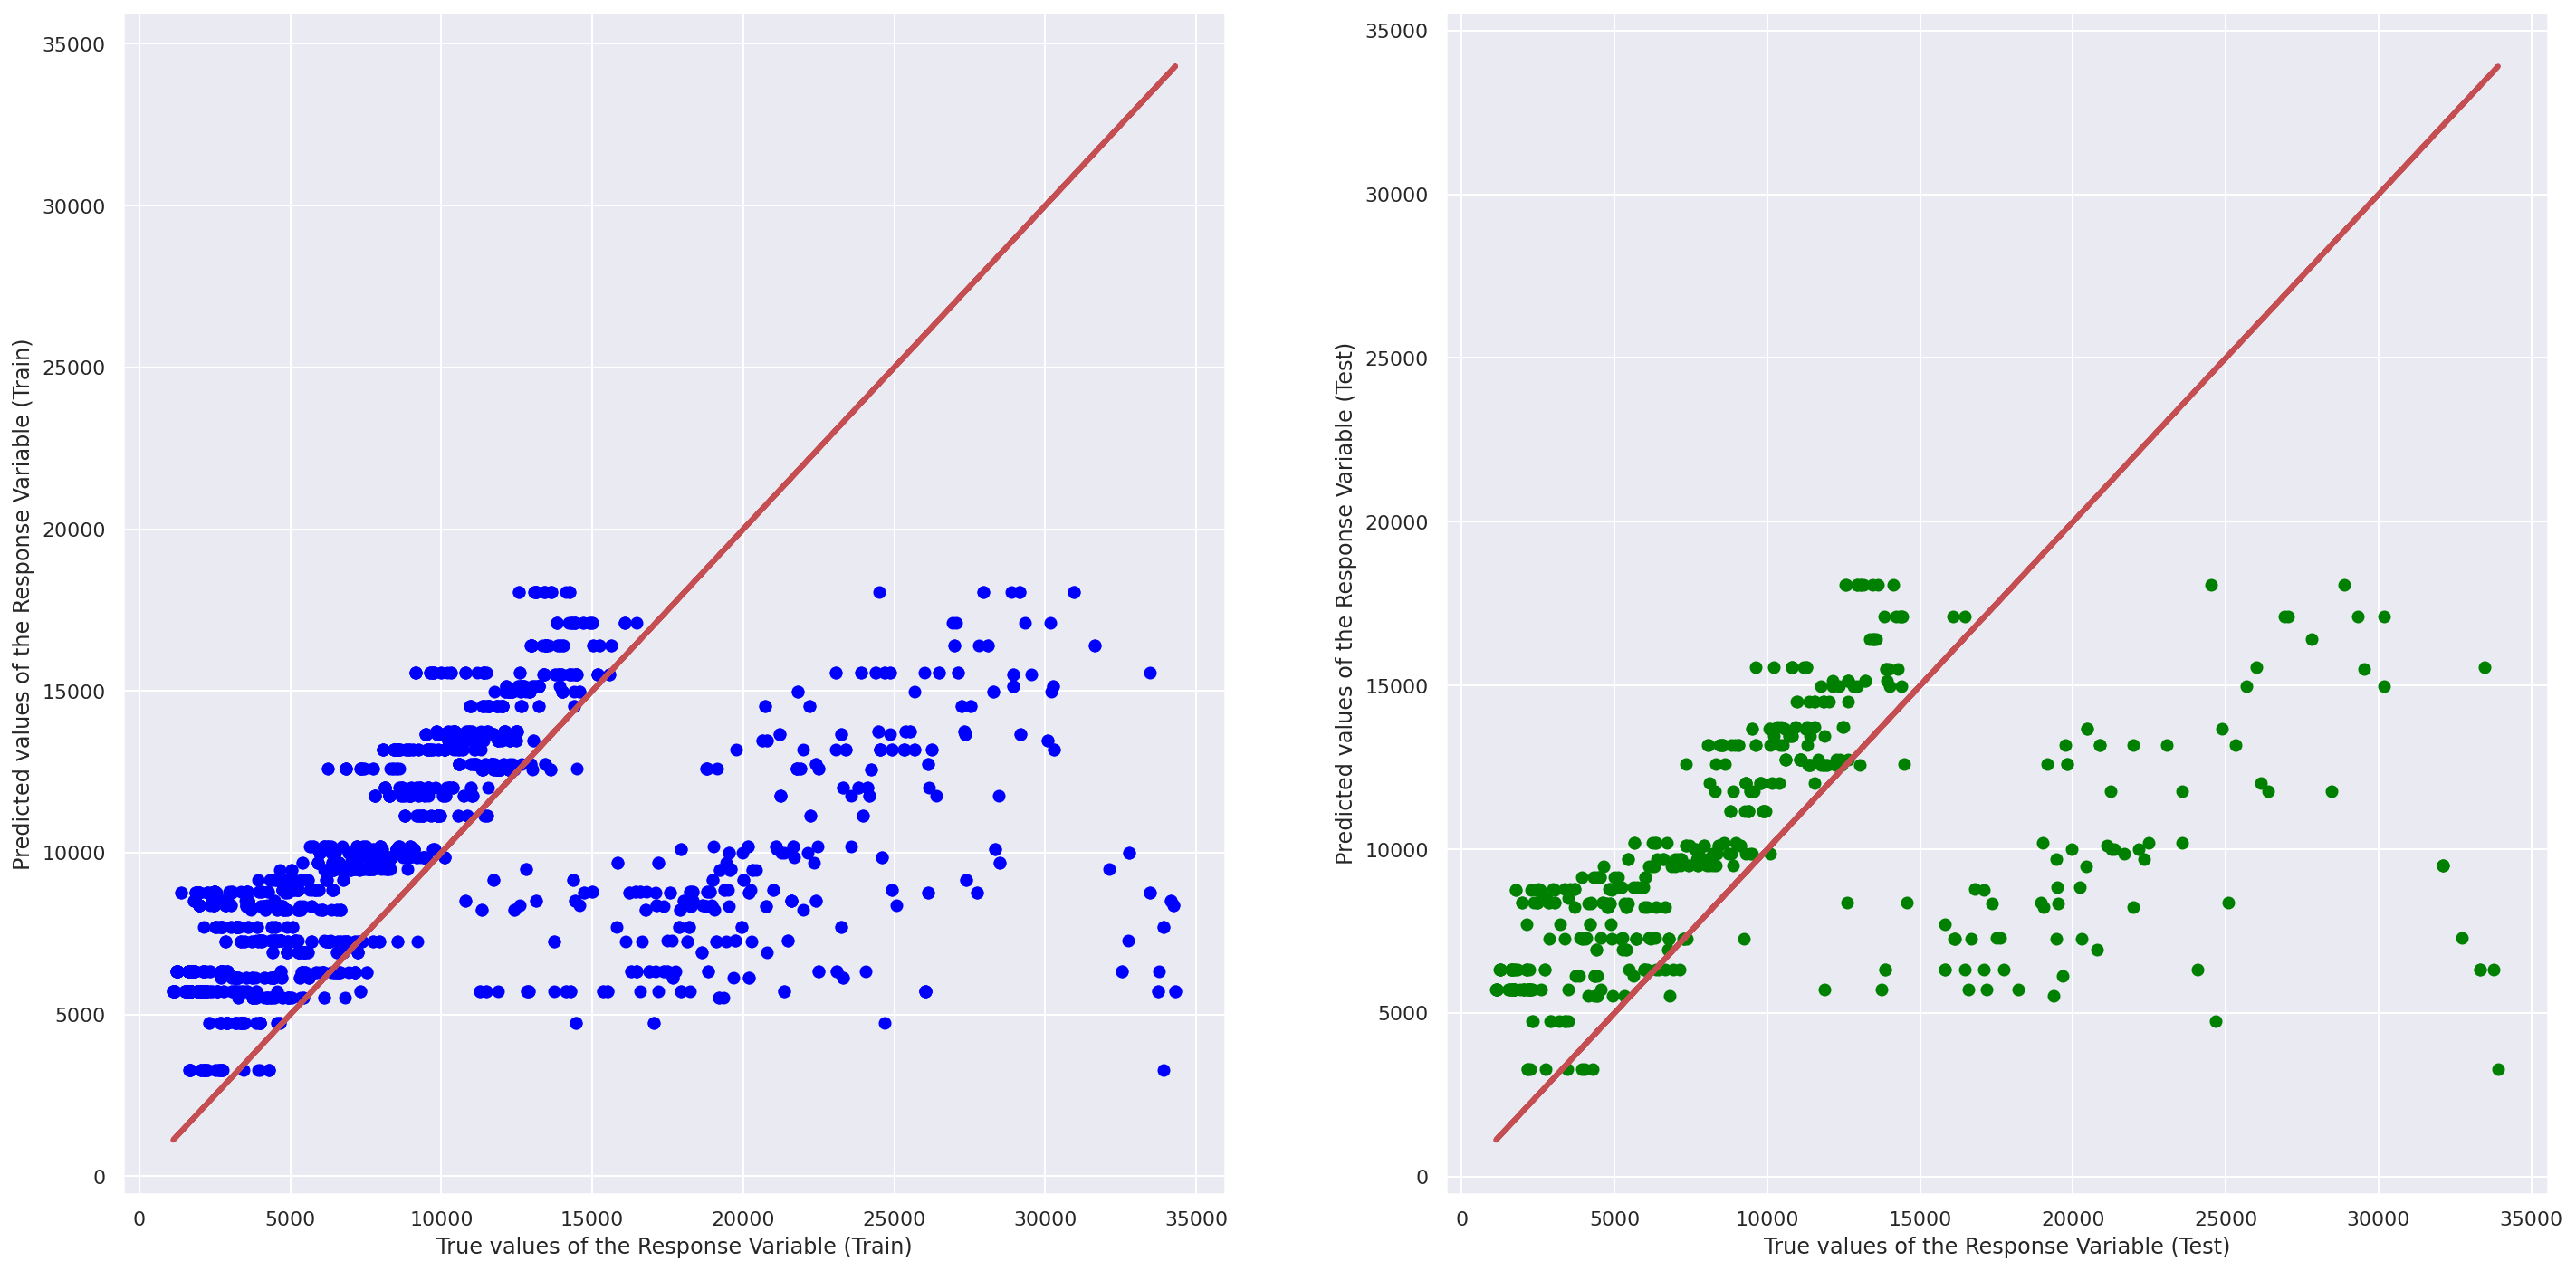

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
random_forest_model.fit(X_train, y_train)

# Predict on the training set and the test set
y_train_pred_rf = random_forest_model.predict(X_train)
y_test_pred_rf = random_forest_model.predict(X_test)

# Calculate the mean squared error
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)

# Calculate the coefficient of determination (R^2)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

# Print out the metrics
print(f'Train MSE: {mse_train_rf}')
print(f'Test MSE: {mse_test_rf}')
print(f'Train R^2: {r2_train_rf}')
print(f'Test R^2: {r2_test_rf}')

# Visualizing the results with scatter plots
import matplotlib.pyplot as plt

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred_rf, color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 3)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred_rf, color = "green")
axes[1].plot(y_test, y_test, 'r-', linewidth = 3)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the threshold for 'high' charges as the 75th percentile of the 'charges' distribution
charges_threshold = medIn_cleaned_copy['charges'].quantile(0.75)

# Create a binary target variable based on the threshold
medIn_cleaned_copy['high_charges'] = (medIn_cleaned_copy['charges'] > charges_threshold).astype(int)

# Define the feature matrix and target vector
X_5 = medIn_cleaned_copy[['sex','smoker','healthyweight', 'age', 'children']]
y_5 = medIn_cleaned_copy['high_charges']

# Split data into training and testing sets
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
log_reg_5 = LogisticRegression(max_iter=1000, random_state = 42)
log_reg_5.fit(X_train_5, y_train_5)

# Make predictions on the test set
y_pred_5 = log_reg_5.predict(X_test_5)

# Evaluate the model
accuracy_5 = accuracy_score(y_test_5, y_pred_5)
conf_matrix_5 = confusion_matrix(y_test_5, y_pred_5)
class_report_5 = classification_report(y_test_5, y_pred_5)

# Output the evaluation metrics
print("Accuracy:", accuracy_5)
print("\nConfusion Matrix:")
print(conf_matrix_5)
print("\nClassification Report:")
print(class_report_5)

Accuracy: 0.875

Confusion Matrix:
[[380   0]
 [ 62  54]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       380
           1       1.00      0.47      0.64       116

    accuracy                           0.88       496
   macro avg       0.93      0.73      0.78       496
weighted avg       0.89      0.88      0.86       496



In [ ]:
print(charges_threshold)

12829.4551


<span style='font-size:medium'>**class 0: Below Threshold**</span>

- <span style='font-size:medium'>Precision is 0.86. This means that among all instances predicted as class 0, 86% were actually class 0.</span>
- <span style='font-size:medium'>Recall is 1.00. This means that among all instances that are actually class 0, the model correctly identified 100% of them.</span>
- <span style='font-size:medium'>F1\-score is 0.92, which is the harmonic mean of precision and recall for class 0.0.</span>

<span style='font-size:medium'>**class 1: Above Threshold**</span><span style='font-size:medium'> </span>

- <span style='font-size:medium'>Precision is 1.00. This means that among all instances predicted as class 1, 100% were actually class 1.</span>

- <span style='font-size:medium'>Recall is 0.47. This means that among all instances that are actually class 1, the model correctly identified 47% of them.</span>

- <span style='font-size:medium'>F1\-score is 0.64, which is the harmonic mean of precision and recall for class 1.</span>

<span style='font-size:medium'>Accuracy: The </span><span style='font-size:medium'>**overall accuracy of model is 0.875 \(3 d.p.\)**</span><span style='font-size:medium'>, meaning that approximately 87.50% of predictions are correct.</span>

<span style='font-size:medium'>Support: Indicates the number of instances for each class in the test data.</span>

<span style='font-size:medium'>**Confusion Matrix:**</span>

- <span style='font-size:medium'>True Negative \(TN\): 380 instances were correctly predicted as class 0.0.</span>

- <span style='font-size:medium'>False Positive \(FP\): 0 instances were incorrectly predicted as class 1.0.</span>

- <span style='font-size:medium'>False Negative \(FN\): 62 instances were incorrectly predicted as class 0.0.</span>

- <span style='font-size:medium'>True Positive \(TP\): 54 instances were correctly predicted as class 1.0</span>

<span style='font-size:medium'>**Prediction Rates:**</span>

- <span style='font-size:medium'>True Positive Rate \(TPR\): 0.46551724</span>
- <span style='font-size:medium'>False Positive Rate \(FPR\): 0</span>

<span style='font-size:medium'>TPR is moderately high, and FPR is 0, which is low.</span>

<span style='font-size:medium'>Overall, performance of model is moderately high, with high precision for class 1 \(above threshold\) and high recall for class 0 \(below threshold\). However, the recall for class 1 is observably lower, suggesting that the model may struggle to correctly predict insurance above the 0.75 threshold \(12829.4551\).</span>  



#### ---Ive edited up to here -----



<span style='font-size:x-large'>**Classification Tree**</span>  



In [1]:
print("Hello")

Hello


## ForestTree Classification



### We observe that explained variance with 2 predictors is higher than that of 1 predictor (age).